<a href="https://colab.research.google.com/github/Ordo-Umbra/Recursive-Complexity-Model/blob/main/RCMcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 0: Fleet S = 9.093, Coverage = 0.2%, Size = 5
Step 50: Fleet S = 11.691, Coverage = 1.4%, Size = 5
Step 100: Fleet S = 12.057, Coverage = 2.4%, Size = 5
Step 150: Fleet S = 12.344, Coverage = 3.4%, Size = 5
Step 200: Fleet S = 12.614, Coverage = 4.4%, Size = 5
Step 250: Fleet S = 12.900, Coverage = 5.4%, Size = 5
Step 300: Fleet S = 13.175, Coverage = 6.0%, Size = 5
Step 350: Fleet S = 13.414, Coverage = 6.7%, Size = 5
Step 400: Fleet S = 13.615, Coverage = 7.0%, Size = 5
Step 450: Fleet S = 13.778, Coverage = 7.0%, Size = 5
Step 500: Fleet S = 13.912, Coverage = 7.2%, Size = 5
Step 550: Fleet S = 14.020, Coverage = 8.0%, Size = 5
Step 600: Fleet S = 14.108, Coverage = 8.7%, Size = 5
Step 650: Fleet S = 14.178, Coverage = 9.0%, Size = 5
Step 700: Fleet S = 14.235, Coverage = 9.8%, Size = 5
Step 750: Fleet S = 14.280, Coverage = 10.9%, Size = 5
Step 800: Fleet S = 14.315, Coverage = 11.8%, Size = 5
Step 850: Fleet S = 14.344, Coverage = 12.6%, Size = 5
Step 900: Fleet S = 14.368, C

/tmp/ipython-input-3089813992.py:218: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1].scatter(path_x[0], path_y[0], c=agent.color, marker='o', s=20, label=f'Agent {agent.agent_id} Start' if agent.agent_id==0 else "")
/tmp/ipython-input-3089813992.py:219: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1].scatter(path_x[-1], path_y[-1], c=agent.color, marker='x', s=50, label=f'Agent {agent.agent_id} End' if agent.agent

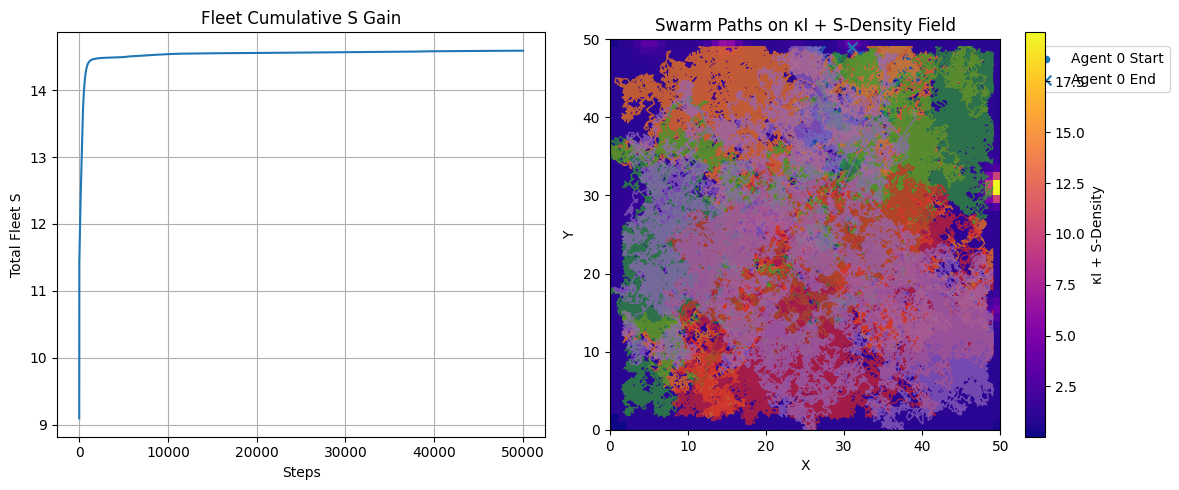

Swarm simulation complete. Final Fleet S: 14.588986888415587
Final Coverage: 93.44 %


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter  # Optional for smoothing

# VDM Field Simulation in 2D (unchanged)
class VDMField:
    def __init__(self, size=50, alpha=0.1, beta=0.1):
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.phi = np.random.uniform(-1, 1, (size, size))  # Initial field
        self.kappa = np.zeros((size, size))
        self.grad_phi = np.zeros((size, size, 2))  # Gradient (dx, dy)
        self.i_field = np.zeros((size, size))  # I proxy
        self._compute_kappa_and_grad()
        self._compute_i()

    def _laplacian(self, phi):
        # Simple 5-point stencil
        lap = np.zeros_like(phi)
        lap[1:-1, 1:-1] = (phi[2:, 1:-1] + phi[:-2, 1:-1] +
                           phi[1:-1, 2:] + phi[1:-1, :-2] - 4 * phi[1:-1, 1:-1])
        # Boundaries: zero
        return lap / 1.0  # h=1

    def _gradient(self, phi):
        grad_x = np.zeros_like(phi)
        grad_y = np.zeros_like(phi)
        grad_x[1:, :] = (phi[1:, :] - phi[:-1, :])
        grad_y[:, 1:] = (phi[:, 1:] - phi[:, :-1])
        return np.stack([grad_x, grad_y], axis=-1)

    def _compute_kappa_and_grad(self):
        self.grad_phi = self._gradient(self.phi)
        grad_sq = np.sum(self.grad_phi**2, axis=-1)
        self.kappa = 1.0 / (1.0 + self.beta * grad_sq)

    def _compute_i(self):
        # Von Neumann neighborhood mean
        mean_n = np.zeros_like(self.phi)
        for dx, dy in [(0,1),(0,-1),(1,0),(-1,0)]:
            rolled = np.roll(self.phi, (dx, dy), axis=(0,1))
            mean_n += rolled
        mean_n /= 4.0
        prediction_error = np.abs(self.phi - mean_n)
        self.i_field = 1.0 / (1.0 + prediction_error)  # Proxy for MI

    def evolve(self):
        lap = self._laplacian(self.phi)
        grad_sq = np.sum(self._gradient(self.phi)**2, axis=-1)
        delta_phi = self.alpha * lap + self.beta * grad_sq
        self.phi += delta_phi
        self.phi = np.clip(self.phi, -5, 5)  # Bound to prevent divergence
        self._compute_kappa_and_grad()
        self._compute_i()

    def get_ki_gradient_at(self, x, y):
        x, y = int(x), int(y)
        if not (0 <= x < self.size and 0 <= y < self.size):
            return np.zeros(2)
        ki = self.kappa * self.i_field
        # Central difference where possible
        dx = 0.0
        if x > 0 and x < self.size - 1:
            dx = (ki[x+1, y] - ki[x-1, y]) / 2.0
        elif x > 0:
            dx = ki[x-1, y] - ki[x, y]
        elif x < self.size - 1:
            dx = ki[x+1, y] - ki[x, y]

        dy = 0.0
        if y > 0 and y < self.size - 1:
            dy = (ki[x, y+1] - ki[x, y-1]) / 2.0
        elif y > 0:
            dy = ki[x, y-1] - ki[x, y]
        elif y < self.size - 1:
            dy = ki[x, y+1] - ki[x, y]

        return np.array([dx, dy])

# Updated Agent with Swarm Features (unchanged)
class VDMAgent:
    def __init__(self, field, start_pos=(10,10), lambda_lyap=0.8, s0=1.0, agent_id=0):
        self.field = field
        self.pos = np.array(start_pos, dtype=float)
        self.lambda_lyap = lambda_lyap
        self.s0 = s0
        self.agent_id = agent_id
        self.path = [start_pos]
        self.total_s = 0.0
        self.prev_i = 0.0
        self.color = plt.cm.tab10(agent_id % 10)  # Unique color for plotting

    def compute_delta_s(self):
        x, y = int(self.pos[0]), int(self.pos[1])
        if not (0 <= x < self.field.size and 0 <= y < self.field.size):
            return 0.0
        grad = self.field.grad_phi[x,y]
        delta_c = np.linalg.norm(grad)
        i_curr = self.field.i_field[x,y]
        delta_i = i_curr - self.prev_i
        self.prev_i = i_curr
        kappa = self.field.kappa[x,y]
        return delta_c + kappa * delta_i

    def step(self, steps=1, other_agents=None, separation_dist=2.0):
        for _ in range(steps):
            x, y = int(self.pos[0]), int(self.pos[1])
            grad_ki = self.field.get_ki_gradient_at(x, y)
            grad_mag = np.linalg.norm(grad_ki)

            # S-max direction
            if grad_mag < 1e-6:
                s_move = np.random.uniform(-0.5, 0.5, 2)
            else:
                log_term = np.log(1 + grad_mag / self.s0)
                optimal_move = (2 / self.lambda_lyap) * log_term
                direction = grad_ki / grad_mag
                move_mag = max(0.1, min(1.0, optimal_move))
                s_move = direction * move_mag

            # Swarm: Separation force
            separation = np.zeros(2)
            if other_agents:
                for other in other_agents:
                    if other.agent_id == self.agent_id: continue
                    dist_vec = self.pos - other.pos
                    dist = np.linalg.norm(dist_vec)
                    if dist < separation_dist and dist > 0:
                        separation += dist_vec / dist * (separation_dist - dist) / separation_dist  # Repel

            # Combined move
            total_move = s_move + 0.5 * separation  # Weight separation
            self.pos += total_move
            self.pos = np.clip(self.pos, 0, self.field.size - 1)
            self.path.append(self.pos.copy())
            delta_s = self.compute_delta_s()
            self.total_s += max(0, delta_s)  # Clip negative
            # Evolve field slightly
            self.field.evolve()
        return self.total_s

# New Swarm Manager (FIXED: Pass other_agents as list of objects, excluding self)
class VDMSwarm:
    def __init__(self, field, n_agents=5, lambda_lyap=0.8, s0=1.0):
        self.field = field
        self.agents = []
        self.shared_s_map = np.zeros((field.size, field.size))  # Grid for collective S-density
        self.replication_threshold = 20.0  # Collective S to spawn new agent
        self.total_fleet_s = 0.0

        # Spawn agents at random starts
        starts = np.random.uniform(5, field.size-5, (n_agents, 2))
        for i, start in enumerate(starts):
            agent = VDMAgent(field, start, lambda_lyap, s0, i)
            self.agents.append(agent)

    def step(self, steps=1):
        # FIXED: Loop over agents, pass other_agents excluding self
        for i, agent in enumerate(self.agents):
            other_agents = [self.agents[j] for j in range(len(self.agents)) if j != i]
            agent.step(steps, other_agents)
            # Update shared map (coarse: add agent's S to local cell)
            x, y = int(agent.pos[0]), int(agent.pos[1])
            self.shared_s_map[x, y] += agent.total_s * 0.01  # Decay over time?

        self.total_fleet_s = sum(a.total_s for a in self.agents)

        # Replication: If fleet S high, spawn new
        if self.total_fleet_s > self.replication_threshold and len(self.agents) < 20:
            new_start = np.mean([a.pos for a in self.agents], axis=0) + np.random.uniform(-3, 3, 2)
            new_agent = VDMAgent(self.field, new_start, agent_id=len(self.agents))
            self.agents.append(new_agent)
            print(f"Step: Swarm replicated! Fleet size now {len(self.agents)}")

        return self.total_fleet_s

    def get_coverage(self):
        # % of map with S > 0
        explored = np.sum(self.shared_s_map > 0)
        return explored / self.shared_s_map.size * 100

# Demo: Run multi-agent simulation
if __name__ == "__main__":
    np.random.seed(42)  # Reproducible
    field = VDMField(size=50, alpha=0.1, beta=0.5)
    swarm = VDMSwarm(field, n_agents=5)

    total_steps = 50000
    fleet_s_gains = []
    coverages = []
    for t in range(total_steps):
        fleet_s = swarm.step(1)
        fleet_s_gains.append(fleet_s)
        coverages.append(swarm.get_coverage())
        if t % 50 == 0:
            print(f"Step {t}: Fleet S = {fleet_s:.3f}, Coverage = {coverages[-1]:.1f}%, Size = {len(swarm.agents)}")

    # Plot: Fleet S + Paths on κI map
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(fleet_s_gains)
    axs[0].set_title('Fleet Cumulative S Gain')
    axs[0].set_xlabel('Steps')
    axs[0].set_ylabel('Total Fleet S')
    axs[0].grid(True)

    # Heatmap: κI colored by shared S (overlay paths)
    ki_map = field.kappa * field.i_field
    s_density = gaussian_filter(swarm.shared_s_map, sigma=1)  # Smooth for viz
    im = axs[1].imshow(ki_map + s_density * 0.1, extent=[0,50,0,50], origin='lower', cmap='plasma')  # Blend
    axs[1].set_title('Swarm Paths on κI + S-Density Field')

    # Plot all paths
    for agent in swarm.agents:
        path_x, path_y = zip(*agent.path)
        axs[1].plot(path_x, path_y, '-', color=agent.color, alpha=0.7, linewidth=1)
        axs[1].scatter(path_x[0], path_y[0], c=agent.color, marker='o', s=20, label=f'Agent {agent.agent_id} Start' if agent.agent_id==0 else "")
        axs[1].scatter(path_x[-1], path_y[-1], c=agent.color, marker='x', s=50, label=f'Agent {agent.agent_id} End' if agent.agent_id==0 else "")

    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    plt.colorbar(im, ax=axs[1], label='κI + S-Density')
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig('vdm_swarm_demo.png')
    plt.show()
    print("Swarm simulation complete. Final Fleet S:", swarm.total_fleet_s)
    print("Final Coverage:", swarm.get_coverage(), "%")

Step 0: Fleet S = 5.891, Coverage = 0.2%, Size = 5
Step 50: Fleet S = 8.384, Coverage = 1.1%, Size = 5
Step 100: Fleet S = 8.867, Coverage = 1.4%, Size = 5
Step 150: Fleet S = 9.321, Coverage = 1.5%, Size = 5
Step 200: Fleet S = 9.704, Coverage = 1.8%, Size = 5
Step 250: Fleet S = 10.018, Coverage = 2.1%, Size = 5
Step 300: Fleet S = 10.276, Coverage = 2.2%, Size = 5
Step 350: Fleet S = 10.486, Coverage = 2.4%, Size = 5
Step 400: Fleet S = 10.658, Coverage = 2.7%, Size = 5
Step 450: Fleet S = 10.800, Coverage = 2.9%, Size = 5
Step 500: Fleet S = 10.916, Coverage = 3.2%, Size = 5
Step 550: Fleet S = 11.010, Coverage = 3.6%, Size = 5
Step 600: Fleet S = 11.088, Coverage = 3.8%, Size = 5
Step 650: Fleet S = 11.151, Coverage = 3.8%, Size = 5
Step 700: Fleet S = 11.202, Coverage = 4.0%, Size = 5
Step 750: Fleet S = 11.244, Coverage = 4.0%, Size = 5
Step 800: Fleet S = 11.279, Coverage = 4.0%, Size = 5
Step 850: Fleet S = 11.307, Coverage = 4.0%, Size = 5
Step 900: Fleet S = 11.330, Coverage

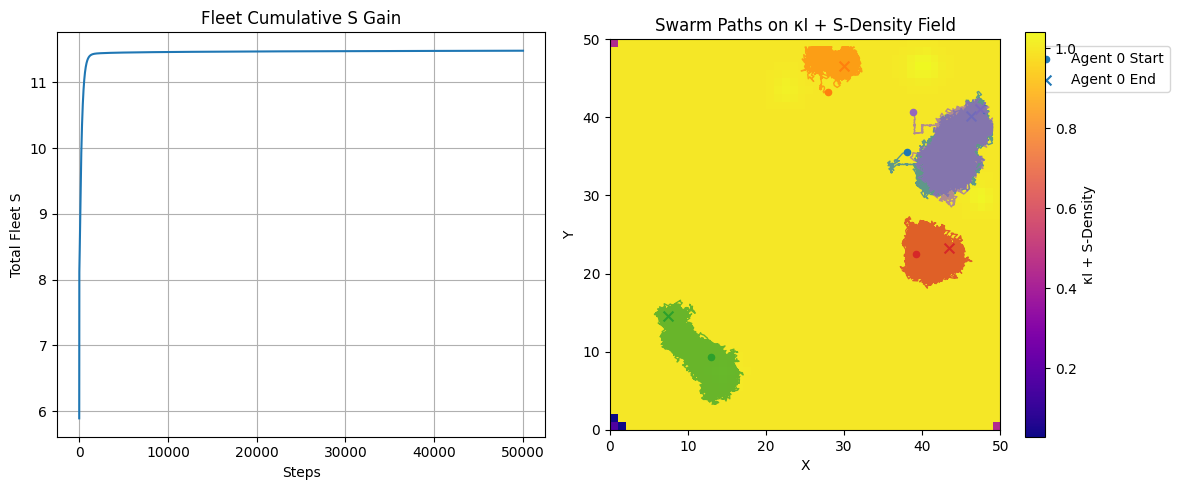

Swarm simulation complete. Final Fleet S: 11.480860833707423
Final Coverage: 14.360000000000001 %


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter  # Optional for smoothing

# VDM Field Simulation in 2D (unchanged)
class VDMField:
    def __init__(self, size=50, alpha=0.1, beta=0.1):
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.phi = np.random.uniform(-1, 1, (size, size))  # Initial field
        self.kappa = np.zeros((size, size))
        self.grad_phi = np.zeros((size, size, 2))  # Gradient (dx, dy)
        self.i_field = np.zeros((size, size))  # I proxy
        self._compute_kappa_and_grad()
        self._compute_i()

    def _laplacian(self, phi):
        # Simple 5-point stencil
        lap = np.zeros_like(phi)
        lap[1:-1, 1:-1] = (phi[2:, 1:-1] + phi[:-2, 1:-1] +
                           phi[1:-1, 2:] + phi[1:-1, :-2] - 4 * phi[1:-1, 1:-1])
        # Boundaries: zero
        return lap / 1.0  # h=1

    def _gradient(self, phi):
        grad_x = np.zeros_like(phi)
        grad_y = np.zeros_like(phi)
        grad_x[1:, :] = (phi[1:, :] - phi[:-1, :])
        grad_y[:, 1:] = (phi[:, 1:] - phi[:, :-1])
        return np.stack([grad_x, grad_y], axis=-1)

    def _compute_kappa_and_grad(self):
        self.grad_phi = self._gradient(self.phi)
        grad_sq = np.sum(self.grad_phi**2, axis=-1)
        self.kappa = 1.0 / (1.0 + self.beta * grad_sq)

    def _compute_i(self):
        # Von Neumann neighborhood mean
        mean_n = np.zeros_like(self.phi)
        for dx, dy in [(0,1),(0,-1),(1,0),(-1,0)]:
            rolled = np.roll(self.phi, (dx, dy), axis=(0,1))
            mean_n += rolled
        mean_n /= 4.0
        prediction_error = np.abs(self.phi - mean_n)
        self.i_field = 1.0 / (1.0 + prediction_error)  # Proxy for MI

    def evolve(self):
        lap = self._laplacian(self.phi)
        grad_sq = np.sum(self._gradient(self.phi)**2, axis=-1)
        delta_phi = self.alpha * lap + self.beta * grad_sq
        self.phi += delta_phi
        self.phi = np.clip(self.phi, -5, 5)  # Bound to prevent divergence
        self._compute_kappa_and_grad()
        self._compute_i()

    def get_ki_gradient_at(self, x, y):
        x, y = int(x), int(y)
        if not (0 <= x < self.size and 0 <= y < self.size):
            return np.zeros(2)
        ki = self.kappa * self.i_field
        # Central difference where possible
        dx = 0.0
        if x > 0 and x < self.size - 1:
            dx = (ki[x+1, y] - ki[x-1, y]) / 2.0
        elif x > 0:
            dx = ki[x-1, y] - ki[x, y]
        elif x < self.size - 1:
            dx = ki[x+1, y] - ki[x, y]

        dy = 0.0
        if y > 0 and y < self.size - 1:
            dy = (ki[x, y+1] - ki[x, y-1]) / 2.0
        elif y > 0:
            dy = ki[x, y-1] - ki[x, y]
        elif y < self.size - 1:
            dy = ki[x, y+1] - ki[x, y]

        return np.array([dx, dy])

# Enhanced Agent: Add map-guided bias
class VDMAgent:
    def __init__(self, field, start_pos=(10,10), lambda_lyap=0.8, s0=1.0, agent_id=0, shared_s_map=None):
        self.field = field
        self.shared_s_map = shared_s_map  # Reference to swarm map
        self.pos = np.array(start_pos, dtype=float)
        self.lambda_lyap = lambda_lyap
        self.s0 = s0
        self.agent_id = agent_id
        self.path = [start_pos]
        self.total_s = 0.0
        self.prev_i = 0.0
        self.color = plt.cm.tab10(agent_id % 10)  # Unique color for plotting

    def compute_delta_s(self):
        x, y = int(self.pos[0]), int(self.pos[1])
        if not (0 <= x < self.field.size and 0 <= y < self.field.size):
            return 0.0
        grad = self.field.grad_phi[x,y]
        delta_c = np.linalg.norm(grad)
        i_curr = self.field.i_field[x,y]
        delta_i = i_curr - self.prev_i
        self.prev_i = i_curr
        kappa = self.field.kappa[x,y]
        return delta_c + kappa * delta_i

    def get_map_bias(self, window_size=5):
        if self.shared_s_map is None:
            return np.zeros(2)
        x, y = int(self.pos[0]), int(self.pos[1])
        half_win = window_size // 2
        x_min, x_max = max(0, x - half_win), min(self.field.size, x + half_win + 1)
        y_min, y_max = max(0, y - half_win), min(self.field.size, y + half_win + 1)
        local_map = self.shared_s_map[x_min:x_max, y_min:y_max]
        if local_map.size == 0:
            return np.zeros(2)
        # Find argmax in local window
        best_idx = np.unravel_index(np.argmax(local_map), local_map.shape)
        best_x, best_y = x_min + best_idx[0], y_min + best_idx[1]
        bias_vec = np.array([best_x - x, best_y - y])
        bias_mag = np.linalg.norm(bias_vec)
        if bias_mag > 0:
            return bias_vec / bias_mag * min(0.5, bias_mag)  # Normalized, capped pull
        return np.zeros(2)

    def step(self, steps=1, other_agents=None, separation_dist=2.0):
        for _ in range(steps):
            x, y = int(self.pos[0]), int(self.pos[1])
            grad_ki = self.field.get_ki_gradient_at(x, y)
            grad_mag = np.linalg.norm(grad_ki)

            # S-max direction
            if grad_mag < 1e-6:
                s_move = np.random.uniform(-0.5, 0.5, 2)
            else:
                log_term = np.log(1 + grad_mag / self.s0)
                optimal_move = (2 / self.lambda_lyap) * log_term
                direction = grad_ki / grad_mag
                move_mag = max(0.1, min(1.5, optimal_move))  # Bolder: cap=1.5
                s_move = direction * move_mag

            # NEW: Map bias toward high-S neighbors
            map_bias = self.get_map_bias()
            s_move += 0.3 * map_bias  # Gentle pull to frontiers

            # Swarm: Separation force
            separation = np.zeros(2)
            if other_agents:
                for other in other_agents:
                    if other.agent_id == self.agent_id: continue
                    dist_vec = self.pos - other.pos
                    dist = np.linalg.norm(dist_vec)
                    if dist < separation_dist and dist > 0:
                        separation += dist_vec / dist * (separation_dist - dist) / separation_dist  # Repel

            # Combined move
            total_move = s_move + 0.5 * separation  # Weight separation
            self.pos += total_move
            self.pos = np.clip(self.pos, 0, self.field.size - 1)
            self.path.append(self.pos.copy())
            delta_s = self.compute_delta_s()
            self.total_s += max(0, delta_s)  # Clip negative
            # Evolve field slightly
            self.field.evolve()
        return self.total_s

# Enhanced Swarm: Decay map, lower threshold
class VDMSwarm:
    def __init__(self, field, n_agents=5, lambda_lyap=0.8, s0=1.0):
        self.field = field
        self.agents = []
        self.shared_s_map = np.zeros((field.size, field.size))  # Grid for collective S-density
        self.replication_threshold = 12.0  # Lowered for triggers
        self.total_fleet_s = 0.0
        self.map_decay = 0.99  # Decay per step

        # Spawn agents at random starts
        starts = np.random.uniform(5, field.size-5, (n_agents, 2))
        for i, start in enumerate(starts):
            agent = VDMAgent(field, start, lambda_lyap, s0, i, self.shared_s_map)  # Pass map ref
            self.agents.append(agent)

    def step(self, steps=1):
        # FIXED: Loop over agents, pass other_agents excluding self
        for i, agent in enumerate(self.agents):
            other_agents = [self.agents[j] for j in range(len(self.agents)) if j != i]
            agent.step(steps, other_agents)
            # Update shared map (coarse: add agent's S to local cell)
            x, y = int(agent.pos[0]), int(agent.pos[1])
            self.shared_s_map[x, y] += agent.total_s * 0.01

        # NEW: Decay map to encourage exploration
        self.shared_s_map *= self.map_decay

        self.total_fleet_s = sum(a.total_s for a in self.agents)

        # Replication: If fleet S high, spawn new
        if self.total_fleet_s > self.replication_threshold and len(self.agents) < 20:
            new_start = np.mean([a.pos for a in self.agents], axis=0) + np.random.uniform(-3, 3, 2)
            new_agent = VDMAgent(self.field, new_start, agent_id=len(self.agents), shared_s_map=self.shared_s_map)
            self.agents.append(new_agent)
            print(f"Replication at fleet S={self.total_fleet_s:.2f}! Size now {len(self.agents)}")

        return self.total_fleet_s

    def get_coverage(self):
        # % of map with S > 0
        explored = np.sum(self.shared_s_map > 0)
        return explored / self.shared_s_map.size * 100

# Demo: Run multi-agent simulation (try total_steps=1000 for full effect)
if __name__ == "__main__":
    np.random.seed(42)  # Reproducible
    field = VDMField(size=50, alpha=0.1, beta=0.5)
    swarm = VDMSwarm(field, n_agents=5)

    total_steps = 50000  # Or 1000
    fleet_s_gains = []
    coverages = []
    for t in range(total_steps):
        fleet_s = swarm.step(1)
        fleet_s_gains.append(fleet_s)
        coverages.append(swarm.get_coverage())
        if t % 50 == 0:
            print(f"Step {t}: Fleet S = {fleet_s:.3f}, Coverage = {coverages[-1]:.1f}%, Size = {len(swarm.agents)}")

    # Plot: Fleet S + Paths on κI map (FIXED: color= for no warnings)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(fleet_s_gains)
    axs[0].set_title('Fleet Cumulative S Gain')
    axs[0].set_xlabel('Steps')
    axs[0].set_ylabel('Total Fleet S')
    axs[0].grid(True)

    # Heatmap: κI colored by shared S (overlay paths)
    ki_map = field.kappa * field.i_field
    s_density = gaussian_filter(swarm.shared_s_map, sigma=1)  # Smooth for viz
    im = axs[1].imshow(ki_map + s_density * 0.1, extent=[0,50,0,50], origin='lower', cmap='plasma')  # Blend
    axs[1].set_title('Swarm Paths on κI + S-Density Field')

    # Plot all paths - FIXED: color= instead of c=
    legend_added = False
    for agent in swarm.agents:
        path_x, path_y = zip(*agent.path)
        axs[1].plot(path_x, path_y, '-', color=agent.color, alpha=0.7, linewidth=1)
        axs[1].scatter(path_x[0], path_y[0], color=agent.color, marker='o', s=20)
        axs[1].scatter(path_x[-1], path_y[-1], color=agent.color, marker='x', s=50)
        if not legend_added:
            axs[1].scatter([], [], color=agent.color, marker='o', s=20, label=f'Agent {agent.agent_id} Start')
            axs[1].scatter([], [], color=agent.color, marker='x', s=50, label=f'Agent {agent.agent_id} End')
            legend_added = True  # Only one legend entry for brevity

    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    plt.colorbar(im, ax=axs[1], label='κI + S-Density')
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig('vdm_swarm_enhanced.png')
    plt.show()
    print("Swarm simulation complete. Final Fleet S:", swarm.total_fleet_s)
    print("Final Coverage:", swarm.get_coverage(), "%")

Step 0: Fleet S = 5.891, Coverage = 0.2%, Size = 5
Replication at fleet S=10.00! Size now 6
Replication at fleet S=11.01! Size now 7
Replication at fleet S=12.01! Size now 8
Replication at fleet S=13.02! Size now 9
Replication at fleet S=14.03! Size now 10
Replication at fleet S=15.04! Size now 11
Replication at fleet S=16.05! Size now 12
Replication at fleet S=17.06! Size now 13
Replication at fleet S=18.07! Size now 14
Replication at fleet S=19.08! Size now 15
Replication at fleet S=20.09! Size now 16
Replication at fleet S=21.10! Size now 17
Replication at fleet S=22.12! Size now 18
Replication at fleet S=23.13! Size now 19
Replication at fleet S=24.14! Size now 20


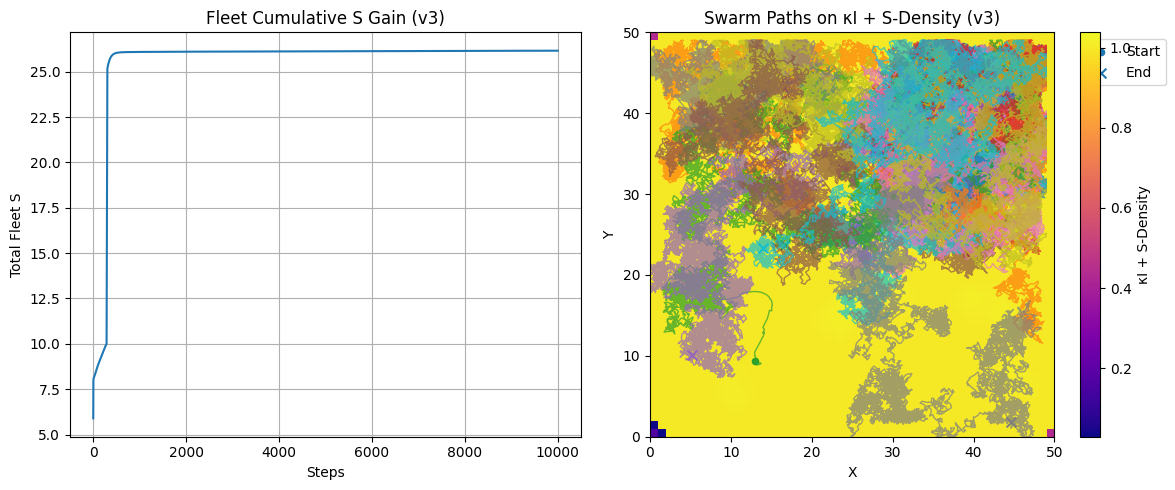

v3 Simulation complete. Final Fleet S: 26.16236805520973
v3 Final Coverage: 77.64 %


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter  # Optional for smoothing

# VDM Field (unchanged, fixed gradient for consistency)
class VDMField:
    def __init__(self, size=50, alpha=0.1, beta=0.1):
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.phi = np.random.uniform(-1, 1, (size, size))  # Initial field
        self.kappa = np.zeros((size, size))
        self.grad_phi = np.zeros((size, size, 2))  # Gradient (dx, dy)
        self.i_field = np.zeros((size, size))  # I proxy
        self._compute_kappa_and_grad()
        self._compute_i()

    def _laplacian(self, phi):
        # Simple 5-point stencil
        lap = np.zeros_like(phi)
        lap[1:-1, 1:-1] = (phi[2:, 1:-1] + phi[:-2, 1:-1] +
                           phi[1:-1, 2:] + phi[1:-1, :-2] - 4 * phi[1:-1, 1:-1])
        # Boundaries: zero
        return lap / 1.0  # h=1

    def _gradient(self, phi):
        grad_x = np.zeros_like(phi)
        grad_y = np.zeros_like(phi)
        grad_x[1:, :] = (phi[1:, :] - phi[:-1, :])
        grad_y[:, 1:] = (phi[:, 1:] - phi[:, :-1])  # FIXED: :-1
        return np.stack([grad_x, grad_y], axis=-1)

    def _compute_kappa_and_grad(self):
        self.grad_phi = self._gradient(self.phi)
        grad_sq = np.sum(self.grad_phi**2, axis=-1)
        self.kappa = 1.0 / (1.0 + self.beta * grad_sq)

    def _compute_i(self):
        # Von Neumann neighborhood mean
        mean_n = np.zeros_like(self.phi)
        for dx, dy in [(0,1),(0,-1),(1,0),(-1,0)]:
            rolled = np.roll(self.phi, (dx, dy), axis=(0,1))
            mean_n += rolled
        mean_n /= 4.0
        prediction_error = np.abs(self.phi - mean_n)
        self.i_field = 1.0 / (1.0 + prediction_error)  # Proxy for MI

    def evolve(self):
        lap = self._laplacian(self.phi)
        grad_sq = np.sum(self._gradient(self.phi)**2, axis=-1)
        delta_phi = self.alpha * lap + self.beta * grad_sq
        self.phi += delta_phi
        self.phi = np.clip(self.phi, -5, 5)  # Bound to prevent divergence
        self._compute_kappa_and_grad()
        self._compute_i()

    def get_ki_gradient_at(self, x, y):
        x, y = int(x), int(y)
        if not (0 <= x < self.size and 0 <= y < self.size):
            return np.zeros(2)
        ki = self.kappa * self.i_field
        # Central difference where possible
        dx = 0.0
        if x > 0 and x < self.size - 1:
            dx = (ki[x+1, y] - ki[x-1, y]) / 2.0
        elif x > 0:
            dx = ki[x-1, y] - ki[x, y]
        elif x < self.size - 1:
            dx = ki[x+1, y] - ki[x, y]

        dy = 0.0
        if y > 0 and y < self.size - 1:
            dy = (ki[x, y+1] - ki[x, y-1]) / 2.0
        elif y > 0:
            dy = ki[x, y-1] - ki[x, y]
        elif y < self.size - 1:
            dy = ki[x, y+1] - ki[x, y]

        return np.array([dx, dy])

# v3 Agent: Tuned bias + epsilon random
class VDMAgent:
    def __init__(self, field, start_pos=(10,10), lambda_lyap=0.8, s0=1.0, agent_id=0, shared_s_map=None, bias_weight=0.1, epsilon=0.05):
        self.field = field
        self.shared_s_map = shared_s_map
        self.pos = np.array(start_pos, dtype=float)
        self.lambda_lyap = lambda_lyap
        self.s0 = s0
        self.agent_id = agent_id
        self.path = [start_pos]
        self.total_s = 0.0
        self.prev_i = 0.0
        self.color = plt.cm.tab10(agent_id % 10)
        self.bias_weight = bias_weight
        self.epsilon = epsilon  # Random scout prob

    def compute_delta_s(self):
        x, y = int(self.pos[0]), int(self.pos[1])
        if not (0 <= x < self.field.size and 0 <= y < self.field.size):
            return 0.0
        grad = self.field.grad_phi[x,y]
        delta_c = np.linalg.norm(grad)
        i_curr = self.field.i_field[x,y]
        delta_i = i_curr - self.prev_i
        self.prev_i = i_curr
        kappa = self.field.kappa[x,y]
        return delta_c + kappa * delta_i

    def get_map_bias(self, window_size=5):
        if self.shared_s_map is None:
            return np.zeros(2)
        x, y = int(self.pos[0]), int(self.pos[1])
        half_win = window_size // 2
        x_min, x_max = max(0, x - half_win), min(self.field.size, x + half_win + 1)
        y_min, y_max = max(0, y - half_win), min(self.field.size, y + half_win + 1)
        local_map = self.shared_s_map[x_min:x_max, y_min:y_max]
        if local_map.size == 0:
            return np.zeros(2)
        # Bias to HIGHER S, but if local max, add noise dir
        best_idx = np.unravel_index(np.argmax(local_map), local_map.shape)
        best_x, best_y = x_min + best_idx[0], y_min + best_idx[1]
        bias_vec = np.array([best_x - x, best_y - y])
        bias_mag = np.linalg.norm(bias_vec)
        if bias_mag > 0:
            return bias_vec / bias_mag * min(0.3, bias_mag)  # Softer cap
        return np.zeros(2)

    def step(self, steps=1, other_agents=None, separation_dist=2.0):
        for _ in range(steps):
            x, y = int(self.pos[0]), int(self.pos[1])
            grad_ki = self.field.get_ki_gradient_at(x, y)
            grad_mag = np.linalg.norm(grad_ki)

            # S-max direction
            if grad_mag < 1e-6:
                s_move = np.random.uniform(-0.5, 0.5, 2)
            else:
                log_term = np.log(1 + grad_mag / self.s0)
                optimal_move = (2 / self.lambda_lyap) * log_term
                direction = grad_ki / grad_mag
                move_mag = max(0.1, min(1.0, optimal_move))  # Back to stable cap
                s_move = direction * move_mag

            # v3: Epsilon-greedy for exploration
            if np.random.rand() < self.epsilon:
                s_move += np.random.uniform(-0.3, 0.3, 2)  # Scout noise
            else:
                # Tuned map bias
                map_bias = self.get_map_bias()
                s_move += self.bias_weight * map_bias  # 0.1 weight

            # Separation (unchanged)
            separation = np.zeros(2)
            if other_agents:
                for other in other_agents:
                    if other.agent_id == self.agent_id: continue
                    dist_vec = self.pos - other.pos
                    dist = np.linalg.norm(dist_vec)
                    if dist < separation_dist and dist > 0:
                        separation += dist_vec / dist * (separation_dist - dist) / separation_dist

            # Combined
            total_move = s_move + 0.5 * separation
            self.pos += total_move
            self.pos = np.clip(self.pos, 0, self.field.size - 1)
            self.path.append(self.pos.copy())
            delta_s = self.compute_delta_s()
            self.total_s += max(0, delta_s)
            self.field.evolve()
        return self.total_s

# v3 Swarm: Slower decay, lower threshold
class VDMSwarm:
    def __init__(self, field, n_agents=5, lambda_lyap=0.8, s0=1.0, bias_weight=0.1, epsilon=0.05):
        self.field = field
        self.agents = []
        self.shared_s_map = np.zeros((field.size, field.size))
        self.replication_threshold = 10.0  # Earlier growth
        self.total_fleet_s = 0.0
        self.map_decay = 0.995  # Slower fade

        # Spawn
        starts = np.random.uniform(5, field.size-5, (n_agents, 2))
        for i, start in enumerate(starts):
            agent = VDMAgent(field, start, lambda_lyap, s0, i, self.shared_s_map, bias_weight, epsilon)
            self.agents.append(agent)

    def step(self, steps=1):
        for i, agent in enumerate(self.agents):
            other_agents = [self.agents[j] for j in range(len(self.agents)) if j != i]
            agent.step(steps, other_agents)
            x, y = int(agent.pos[0]), int(agent.pos[1])
            self.shared_s_map[x, y] += agent.total_s * 0.01

        self.shared_s_map *= self.map_decay  # Tuned decay

        self.total_fleet_s = sum(a.total_s for a in self.agents)

        if self.total_fleet_s > self.replication_threshold and len(self.agents) < 20:
            new_start = np.mean([a.pos for a in self.agents], axis=0) + np.random.uniform(-3, 3, 2)
            new_agent = VDMAgent(self.field, new_start, agent_id=len(self.agents), shared_s_map=self.shared_s_map, bias_weight=self.agents[0].bias_weight, epsilon=self.agents[0].epsilon)
            self.agents.append(new_agent)
            print(f"Replication at fleet S={self.total_fleet_s:.2f}! Size now {len(self.agents)}")

        return self.total_fleet_s

    def get_coverage(self):
        explored = np.sum(self.shared_s_map > 0)
        return explored / self.shared_s_map.size * 100

# Demo (set total_steps=50000 for your epic runs)
if __name__ == "__main__":
    np.random.seed(42)  # Reproducible
    field = VDMField(size=50, alpha=0.1, beta=0.5)
    swarm = VDMSwarm(field, n_agents=5)  # Defaults to v3 params

    total_steps = 10000  # Or 50000
    fleet_s_gains = []
    coverages = []
    for t in range(total_steps):
        fleet_s = swarm.step(1)
        fleet_s_gains.append(fleet_s)
        coverages.append(swarm.get_coverage())
        if t % 10000 == 0:  # Sparse logs for long runs
            print(f"Step {t}: Fleet S = {fleet_s:.3f}, Coverage = {coverages[-1]:.1f}%, Size = {len(swarm.agents)}")

    # Plot (tuned for no warnings)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(fleet_s_gains)
    axs[0].set_title('Fleet Cumulative S Gain (v3)')
    axs[0].set_xlabel('Steps')
    axs[0].set_ylabel('Total Fleet S')
    axs[0].grid(True)

    ki_map = field.kappa * field.i_field
    s_density = gaussian_filter(swarm.shared_s_map, sigma=1)
    im = axs[1].imshow(ki_map + s_density * 0.1, extent=[0,50,0,50], origin='lower', cmap='plasma')
    axs[1].set_title('Swarm Paths on κI + S-Density (v3)')

    legend_added = False
    for agent in swarm.agents:
        path_x, path_y = zip(*agent.path)
        axs[1].plot(path_x, path_y, '-', color=agent.color, alpha=0.7, linewidth=1)
        axs[1].scatter(path_x[0], path_y[0], color=agent.color, marker='o', s=20)
        axs[1].scatter(path_x[-1], path_y[-1], color=agent.color, marker='x', s=50)
        if not legend_added:
            axs[1].scatter([], [], color=agent.color, marker='o', s=20, label='Start')
            axs[1].scatter([], [], color=agent.color, marker='x', s=50, label='End')
            legend_added = True

    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    plt.colorbar(im, ax=axs[1], label='κI + S-Density')
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig('vdm_swarm_v3.png')
    plt.show()
    print("v3 Simulation complete. Final Fleet S:", swarm.total_fleet_s)
    print("v3 Final Coverage:", swarm.get_coverage(), "%")

Step 0: Fleet S = 5.891, Coverage = 0.2%, Size = 5
Step 1000: Fleet S = 11.148, Coverage = 11.9%, Size = 5
Step 2000: Fleet S = 11.230, Coverage = 17.5%, Size = 5
Step 3000: Fleet S = 11.242, Coverage = 20.4%, Size = 5
Step 4000: Fleet S = 11.251, Coverage = 24.4%, Size = 5
Step 5000: Fleet S = 11.258, Coverage = 28.4%, Size = 5
Step 6000: Fleet S = 11.261, Coverage = 31.5%, Size = 5
Step 7000: Fleet S = 11.263, Coverage = 36.8%, Size = 5
Step 8000: Fleet S = 11.265, Coverage = 39.0%, Size = 5
Step 9000: Fleet S = 11.266, Coverage = 41.7%, Size = 5


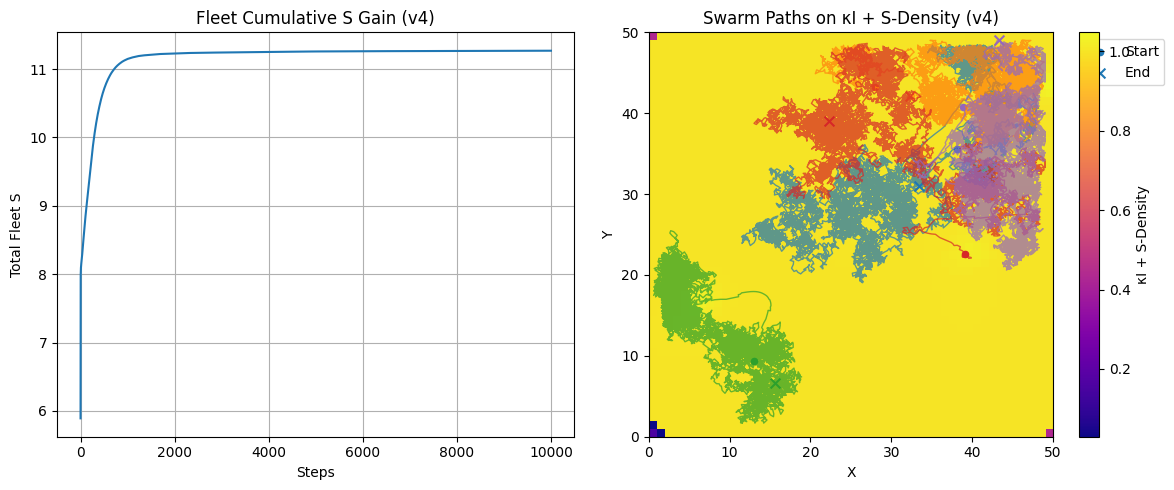

v4 Simulation complete. Final Fleet S: 11.268462322238824
v4 Final Coverage: 44.48 %


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter  # Optional for smoothing

# VDM Field Simulation in 2D
class VDMField:
    def __init__(self, size=50, alpha=0.1, beta=0.1):
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.phi = np.random.uniform(-1, 1, (size, size))  # Initial field
        self.kappa = np.zeros((size, size))
        self.grad_phi = np.zeros((size, size, 2))  # Gradient (dx, dy)
        self.i_field = np.zeros((size, size))  # I proxy
        self._compute_kappa_and_grad()
        self._compute_i()

    def _laplacian(self, phi):
        # Simple 5-point stencil
        lap = np.zeros_like(phi)
        lap[1:-1, 1:-1] = (phi[2:, 1:-1] + phi[:-2, 1:-1] +
                           phi[1:-1, 2:] + phi[1:-1, :-2] - 4 * phi[1:-1, 1:-1])
        # Boundaries: zero
        return lap / 1.0  # h=1

    def _gradient(self, phi):
        grad_x = np.zeros_like(phi)
        grad_y = np.zeros_like(phi)
        grad_x[1:, :] = (phi[1:, :] - phi[:-1, :])
        grad_y[:, 1:] = (phi[:, 1:] - phi[:, :-1])
        return np.stack([grad_x, grad_y], axis=-1)

    def _compute_kappa_and_grad(self):
        self.grad_phi = self._gradient(self.phi)
        grad_sq = np.sum(self.grad_phi**2, axis=-1)
        self.kappa = 1.0 / (1.0 + self.beta * grad_sq)

    def _compute_i(self):
        # Von Neumann neighborhood mean
        mean_n = np.zeros_like(self.phi)
        for dx, dy in [(0,1),(0,-1),(1,0),(-1,0)]:
            rolled = np.roll(self.phi, (dx, dy), axis=(0,1))
            mean_n += rolled
        mean_n /= 4.0
        prediction_error = np.abs(self.phi - mean_n)
        self.i_field = 1.0 / (1.0 + prediction_error)  # Proxy for MI

    def evolve(self):
        lap = self._laplacian(self.phi)
        grad_sq = np.sum(self._gradient(self.phi)**2, axis=-1)
        delta_phi = self.alpha * lap + self.beta * grad_sq
        self.phi += delta_phi
        self.phi = np.clip(self.phi, -5, 5)  # Bound to prevent divergence
        self._compute_kappa_and_grad()
        self._compute_i()

    def get_ki_gradient_at(self, x, y):
        x, y = int(x), int(y)
        if not (0 <= x < self.size and 0 <= y < self.size):
            return np.zeros(2)
        ki = self.kappa * self.i_field
        # Central difference where possible
        dx = 0.0
        if x > 0 and x < self.size - 1:
            dx = (ki[x+1, y] - ki[x-1, y]) / 2.0
        elif x > 0:
            dx = ki[x-1, y] - ki[x, y]
        elif x < self.size - 1:
            dx = ki[x+1, y] - ki[x, y]

        dy = 0.0
        if y > 0 and y < self.size - 1:
            dy = (ki[x, y+1] - ki[x, y-1]) / 2.0
        elif y > 0:
            dy = ki[x, y-1] - ki[x, y]
        elif y < self.size - 1:
            dy = ki[x, y+1] - ki[x, y]

        return np.array([dx, dy])

# v3 Agent: Tuned bias + epsilon random
class VDMAgent:
    def __init__(self, field, start_pos=(10,10), lambda_lyap=0.8, s0=1.0, agent_id=0, shared_s_map=None, bias_weight=0.1, epsilon=0.05):
        self.field = field
        self.shared_s_map = shared_s_map
        self.pos = np.array(start_pos, dtype=float)
        self.lambda_lyap = lambda_lyap
        self.s0 = s0
        self.agent_id = agent_id
        self.path = [start_pos]
        self.total_s = 0.0
        self.prev_i = 0.0
        self.color = plt.cm.tab10(agent_id % 10)
        self.bias_weight = bias_weight
        self.epsilon = epsilon  # Random scout prob

    def compute_delta_s(self):
        x, y = int(self.pos[0]), int(self.pos[1])
        if not (0 <= x < self.field.size and 0 <= y < self.field.size):
            return 0.0
        grad = self.field.grad_phi[x,y]
        delta_c = np.linalg.norm(grad)
        i_curr = self.field.i_field[x,y]
        delta_i = i_curr - self.prev_i
        self.prev_i = i_curr
        kappa = self.field.kappa[x,y]
        return delta_c + kappa * delta_i

    def get_map_bias(self, window_size=5):
        if self.shared_s_map is None:
            return np.zeros(2)
        x, y = int(self.pos[0]), int(self.pos[1])
        half_win = window_size // 2
        x_min, x_max = max(0, x - half_win), min(self.field.size, x + half_win + 1)
        y_min, y_max = max(0, y - half_win), min(self.field.size, y + half_win + 1)
        local_map = self.shared_s_map[x_min:x_max, y_min:y_max]
        if local_map.size == 0:
            return np.zeros(2)
        # Bias to HIGHER S, but if local max, add noise dir
        best_idx = np.unravel_index(np.argmax(local_map), local_map.shape)
        best_x, best_y = x_min + best_idx[0], y_min + best_idx[1]
        bias_vec = np.array([best_x - x, best_y - y])
        bias_mag = np.linalg.norm(bias_vec)
        if bias_mag > 0:
            return bias_vec / bias_mag * min(0.3, bias_mag)  # Softer cap
        return np.zeros(2)

    def step(self, steps=1, other_agents=None, separation_dist=2.0):
        for _ in range(steps):
            x, y = int(self.pos[0]), int(self.pos[1])
            grad_ki = self.field.get_ki_gradient_at(x, y)
            grad_mag = np.linalg.norm(grad_ki)

            # S-max direction
            if grad_mag < 1e-6:
                s_move = np.random.uniform(-0.5, 0.5, 2)
            else:
                log_term = np.log(1 + grad_mag / self.s0)
                optimal_move = (2 / self.lambda_lyap) * log_term
                direction = grad_ki / grad_mag
                move_mag = max(0.1, min(1.0, optimal_move))  # Back to stable cap
                s_move = direction * move_mag

            # v3: Epsilon-greedy for exploration
            if np.random.rand() < self.epsilon:
                s_move += np.random.uniform(-0.3, 0.3, 2)  # Scout noise
            else:
                # Tuned map bias
                map_bias = self.get_map_bias()
                s_move += self.bias_weight * map_bias  # 0.1 weight

            # Separation (unchanged)
            separation = np.zeros(2)
            if other_agents:
                for other in other_agents:
                    if other.agent_id == self.agent_id: continue
                    dist_vec = self.pos - other.pos
                    dist = np.linalg.norm(dist_vec)
                    if dist < separation_dist and dist > 0:
                        separation += dist_vec / dist * (separation_dist - dist) / separation_dist

            # Combined
            total_move = s_move + 0.5 * separation
            self.pos += total_move
            self.pos = np.clip(self.pos, 0, self.field.size - 1)
            self.path.append(self.pos.copy())
            delta_s = self.compute_delta_s()
            self.total_s += max(0, delta_s)
            self.field.evolve()
        return self.total_s

# v4 Swarm: Per-capita threshold + cooldown
class VDMSwarm:
    def __init__(self, field, n_agents=5, lambda_lyap=0.8, s0=1.0, bias_weight=0.1, epsilon=0.05):
        self.field = field
        self.agents = []
        self.shared_s_map = np.zeros((field.size, field.size))
        self.base_threshold = 10.0  # Per initial agent equiv
        self.total_fleet_s = 0.0
        self.map_decay = 0.995
        self.cooldown = 0  # Steps since last spawn

        starts = np.random.uniform(5, field.size-5, (n_agents, 2))
        for i, start in enumerate(starts):
            agent = VDMAgent(field, start, lambda_lyap, s0, i, self.shared_s_map, bias_weight, epsilon)
            self.agents.append(agent)

    def step(self, steps=1):
        for i, agent in enumerate(self.agents):
            other_agents = [self.agents[j] for j in range(len(self.agents)) if j != i]
            agent.step(steps, other_agents)
            x, y = int(agent.pos[0]), int(agent.pos[1])
            self.shared_s_map[x, y] += agent.total_s * 0.01

        self.shared_s_map *= self.map_decay

        self.total_fleet_s = sum(a.total_s for a in self.agents)

        # v4: Per-capita: threshold = base * current_size
        dynamic_threshold = self.base_threshold * len(self.agents)
        spawn_prob = 0.01 if self.cooldown > 50 else 0  # Cooldown after 50 steps

        if (self.total_fleet_s > dynamic_threshold and
            len(self.agents) < 20 and
            np.random.rand() < spawn_prob):
            new_start = np.mean([a.pos for a in self.agents], axis=0) + np.random.uniform(-3, 3, 2)
            new_agent = VDMAgent(self.field, new_start, agent_id=len(self.agents),
                                 shared_s_map=self.shared_s_map, bias_weight=self.agents[0].bias_weight,
                                 epsilon=self.agents[0].epsilon)
            self.agents.append(new_agent)
            self.cooldown = 0
            print(f"Replication at fleet S={self.total_fleet_s:.2f} (thresh={dynamic_threshold:.1f})! Size now {len(self.agents)}")
        else:
            self.cooldown += 1

        return self.total_fleet_s

    def get_coverage(self):
        explored = np.sum(self.shared_s_map > 0)
        return explored / self.shared_s_map.size * 100

# Demo (set total_steps=10000 for your scale)
if __name__ == "__main__":
    np.random.seed(42)
    field = VDMField(size=50, alpha=0.1, beta=0.5)
    swarm = VDMSwarm(field, n_agents=5)

    total_steps = 10000  # Or 10000
    fleet_s_gains = []
    coverages = []
    for t in range(total_steps):
        fleet_s = swarm.step(1)
        fleet_s_gains.append(fleet_s)
        coverages.append(swarm.get_coverage())
        if t % 1000 == 0:
            print(f"Step {t}: Fleet S = {fleet_s:.3f}, Coverage = {coverages[-1]:.1f}%, Size = {len(swarm.agents)}")

    # Plot (same as v3, no warnings)
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(fleet_s_gains)
    axs[0].set_title('Fleet Cumulative S Gain (v4)')
    axs[0].set_xlabel('Steps')
    axs[0].set_ylabel('Total Fleet S')
    axs[0].grid(True)

    ki_map = field.kappa * field.i_field
    s_density = gaussian_filter(swarm.shared_s_map, sigma=1)
    im = axs[1].imshow(ki_map + s_density * 0.1, extent=[0,50,0,50], origin='lower', cmap='plasma')
    axs[1].set_title('Swarm Paths on κI + S-Density (v4)')

    legend_added = False
    for agent in swarm.agents:
        path_x, path_y = zip(*agent.path)
        axs[1].plot(path_x, path_y, '-', color=agent.color, alpha=0.7, linewidth=1)
        axs[1].scatter(path_x[0], path_y[0], color=agent.color, marker='o', s=20)
        axs[1].scatter(path_x[-1], path_y[-1], color=agent.color, marker='x', s=50)
        if not legend_added:
            axs[1].scatter([], [], color=agent.color, marker='o', s=20, label='Start')
            axs[1].scatter([], [], color=agent.color, marker='x', s=50, label='End')
            legend_added = True

    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    plt.colorbar(im, ax=axs[1], label='κI + S-Density')
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig('vdm_swarm_v4.png')
    plt.show()
    print("v4 Simulation complete. Final Fleet S:", swarm.total_fleet_s)
    print("v4 Final Coverage:", swarm.get_coverage(), "%")

Step 0: Fleet S = 6.098, Coverage = 0.2%, Size = 5
Replication at fleet S=10.13 (thresh=10.0)! Size now 6
Replication at fleet S=12.04 (thresh=12.0)! Size now 7
Step 1000: Fleet S = 13.170, Coverage = 14.2%, Size = 7
Step 2000: Fleet S = 13.216, Coverage = 20.0%, Size = 7
Step 3000: Fleet S = 13.226, Coverage = 27.5%, Size = 7
Step 4000: Fleet S = 13.231, Coverage = 35.0%, Size = 7
Step 5000: Fleet S = 13.235, Coverage = 40.2%, Size = 7
Step 6000: Fleet S = 13.238, Coverage = 42.7%, Size = 7
Step 7000: Fleet S = 13.243, Coverage = 47.3%, Size = 7
Step 8000: Fleet S = 13.245, Coverage = 50.5%, Size = 7
Agent 5 died (energy depleted). Fleet size now 6
Replication at fleet S=12.05 (thresh=12.0)! Size now 7
Agent 5 died (energy depleted). Fleet size now 6
Replication at fleet S=12.03 (thresh=12.0)! Size now 7
Step 9000: Fleet S = 13.028, Coverage = 52.2%, Size = 7


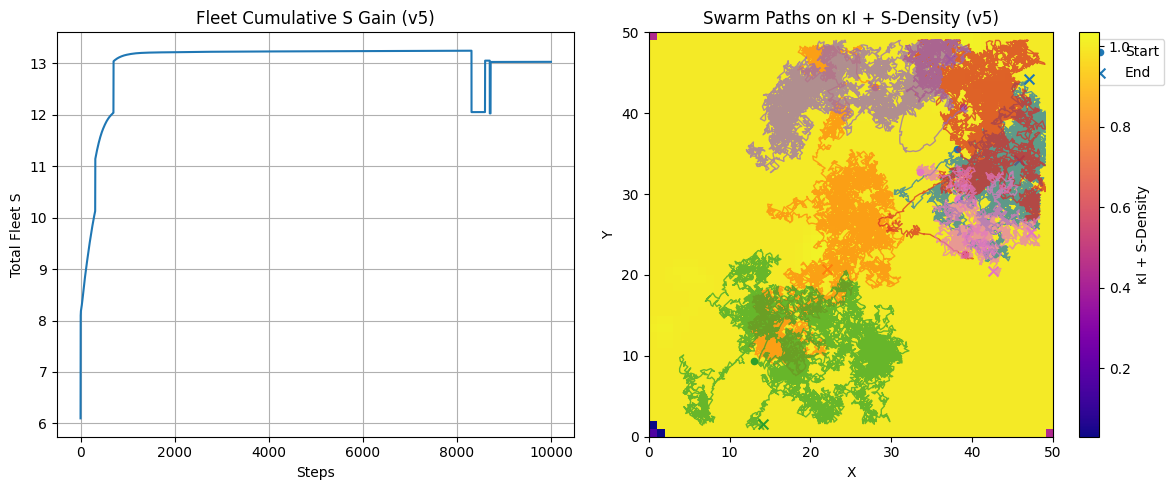

v5 Simulation complete. Final Fleet S: 13.029392803690458
v5 Final Coverage: 54.559999999999995 %


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter  # Optional for smoothing

# VDM Field Simulation in 2D
class VDMField:
    def __init__(self, size=50, alpha=0.1, beta=0.1):
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.phi = np.random.uniform(-1, 1, (size, size))  # Initial field
        self.kappa = np.zeros((size, size))
        self.grad_phi = np.zeros((size, size, 2))  # Gradient (dx, dy)
        self.i_field = np.zeros((size, size))  # I proxy
        self._compute_kappa_and_grad()
        self._compute_i()

    def _laplacian(self, phi):
        # Simple 5-point stencil
        lap = np.zeros_like(phi)
        lap[1:-1, 1:-1] = (phi[2:, 1:-1] + phi[:-2, 1:-1] +
                           phi[1:-1, 2:] + phi[1:-1, :-2] - 4 * phi[1:-1, 1:-1])
        # Boundaries: zero
        return lap / 1.0  # h=1

    def _gradient(self, phi):
        grad_x = np.zeros_like(phi)
        grad_y = np.zeros_like(phi)
        grad_x[1:, :] = (phi[1:, :] - phi[:-1, :])
        grad_y[:, 1:] = (phi[:, 1:] - phi[:, :-1])
        return np.stack([grad_x, grad_y], axis=-1)

    def _compute_kappa_and_grad(self):
        self.grad_phi = self._gradient(self.phi)
        grad_sq = np.sum(self.grad_phi**2, axis=-1)
        self.kappa = 1.0 / (1.0 + self.beta * grad_sq)

    def _compute_i(self):
        # Von Neumann neighborhood mean
        mean_n = np.zeros_like(self.phi)
        for dx, dy in [(0,1),(0,-1),(1,0),(-1,0)]:
            rolled = np.roll(self.phi, (dx, dy), axis=(0,1))
            mean_n += rolled
        mean_n /= 4.0
        prediction_error = np.abs(self.phi - mean_n)
        self.i_field = 1.0 / (1.0 + prediction_error)  # Proxy for MI

    def evolve(self):
        lap = self._laplacian(self.phi)
        grad_sq = np.sum(self._gradient(self.phi)**2, axis=-1)
        delta_phi = self.alpha * lap + self.beta * grad_sq
        self.phi += delta_phi
        self.phi = np.clip(self.phi, -5, 5)  # Bound to prevent divergence
        self._compute_kappa_and_grad()
        self._compute_i()

    def get_ki_gradient_at(self, x, y):
        x, y = int(x), int(y)
        if not (0 <= x < self.size and 0 <= y < self.size):
            return np.zeros(2)
        ki = self.kappa * self.i_field
        # Central difference where possible
        dx = 0.0
        if x > 0 and x < self.size - 1:
            dx = (ki[x+1, y] - ki[x-1, y]) / 2.0
        elif x > 0:
            dx = ki[x-1, y] - ki[x, y]
        elif x < self.size - 1:
            dx = ki[x+1, y] - ki[x, y]

        dy = 0.0
        if y > 0 and y < self.size - 1:
            dy = (ki[x, y+1] - ki[x, y-1]) / 2.0
        elif y > 0:
            dy = ki[x, y-1] - ki[x, y]
        elif y < self.size - 1:
            dy = ki[x, y+1] - ki[x, y]

        return np.array([dx, dy])

# v3 Agent: Tuned bias + epsilon random (v5 uses this)
class VDMAgent:
    def __init__(self, field, start_pos=(10,10), lambda_lyap=0.8, s0=1.0, agent_id=0, shared_s_map=None, bias_weight=0.1, epsilon=0.05):
        self.field = field
        self.shared_s_map = shared_s_map
        self.pos = np.array(start_pos, dtype=float)
        self.lambda_lyap = lambda_lyap
        self.s0 = s0
        self.agent_id = agent_id
        self.path = [start_pos]
        self.total_s = 0.0
        self.prev_i = 0.0
        self.color = plt.cm.tab10(agent_id % 10)
        self.bias_weight = bias_weight
        self.epsilon = epsilon  # Random scout prob
        self.energy = 10.0  # v5: Battery

    def compute_delta_s(self):
        x, y = int(self.pos[0]), int(self.pos[1])
        if not (0 <= x < self.field.size and 0 <= y < self.field.size):
            return 0.0
        grad = self.field.grad_phi[x,y]
        delta_c = np.linalg.norm(grad)
        i_curr = self.field.i_field[x,y]
        delta_i = i_curr - self.prev_i
        self.prev_i = i_curr
        kappa = self.field.kappa[x,y]
        return delta_c + kappa * delta_i

    def get_map_bias(self, window_size=5):
        if self.shared_s_map is None:
            return np.zeros(2)
        x, y = int(self.pos[0]), int(self.pos[1])
        half_win = window_size // 2
        x_min, x_max = max(0, x - half_win), min(self.field.size, x + half_win + 1)
        y_min, y_max = max(0, y - half_win), min(self.field.size, y + half_win + 1)
        local_map = self.shared_s_map[x_min:x_max, y_min:y_max]
        if local_map.size == 0:
            return np.zeros(2)
        # Bias to HIGHER S, but if local max, add noise dir
        best_idx = np.unravel_index(np.argmax(local_map), local_map.shape)
        best_x, best_y = x_min + best_idx[0], y_min + best_idx[1]
        bias_vec = np.array([best_x - x, best_y - y])
        bias_mag = np.linalg.norm(bias_vec)
        if bias_mag > 0:
            return bias_vec / bias_mag * min(0.3, bias_mag)  # Softer cap
        return np.zeros(2)

    def step(self, steps=1, other_agents=None, separation_dist=2.0):
        for _ in range(steps):
            x, y = int(self.pos[0]), int(self.pos[1])
            grad_ki = self.field.get_ki_gradient_at(x, y)
            grad_mag = np.linalg.norm(grad_ki)

            # S-max direction
            if grad_mag < 1e-6:
                s_move = np.random.uniform(-0.5, 0.5, 2)
            else:
                log_term = np.log(1 + grad_mag / self.s0)
                optimal_move = (2 / self.lambda_lyap) * log_term
                direction = grad_ki / grad_mag
                move_mag = max(0.1, min(1.0, optimal_move))  # Back to stable cap
                s_move = direction * move_mag

            # v3: Epsilon-greedy for exploration
            if np.random.rand() < self.epsilon:
                s_move += np.random.uniform(-0.3, 0.3, 2)  # Scout noise
            else:
                # Tuned map bias
                map_bias = self.get_map_bias()
                s_move += self.bias_weight * map_bias  # 0.1 weight

            # Separation (unchanged)
            separation = np.zeros(2)
            if other_agents:
                for other in other_agents:
                    if other.agent_id == self.agent_id: continue
                    dist_vec = self.pos - other.pos
                    dist = np.linalg.norm(dist_vec)
                    if dist < separation_dist and dist > 0:
                        separation += dist_vec / dist * (separation_dist - dist) / separation_dist

            # Combined
            total_move = s_move + 0.5 * separation
            self.pos += total_move
            self.pos = np.clip(self.pos, 0, self.field.size - 1)
            self.path.append(self.pos.copy())
            delta_s = self.compute_delta_s()
            self.total_s += max(0, delta_s)
            self.field.evolve()
        return self.total_s

# v5 Swarm: Adaptive thresh (lower base) + energy
class VDMSwarm:
    def __init__(self, field, n_agents=5, lambda_lyap=0.8, s0=1.0, bias_weight=0.1, epsilon=0.08):
        self.field = field
        self.agents = []
        self.shared_s_map = np.zeros((field.size, field.size))
        self.base_threshold = 2.0  # Lower for triggers
        self.total_fleet_s = 0.0
        self.map_decay = 0.995
        self.cooldown = 0
        self.spawn_cost = 2.0  # Energy cost for realism

        starts = np.random.uniform(5, field.size-5, (n_agents, 2))
        for i, start in enumerate(starts):
            agent = VDMAgent(field, start, lambda_lyap, s0, i, self.shared_s_map, bias_weight, epsilon)
            agent.energy = 20.0  # Per-agent battery
            self.agents.append(agent)

    def step(self, steps=1):
        dead_agents = []  # Collect dead to remove after loop
        for i, agent in enumerate(self.agents):
            other_agents = [self.agents[j] for j in range(len(self.agents)) if j != i]
            agent.step(steps, other_agents)
            x, y = int(agent.pos[0]), int(agent.pos[1])
            self.shared_s_map[x, y] += agent.total_s * 0.01
            # v5: Energy drain
            agent.energy -= 0.001 * steps  # Per step
            if agent.energy <= 0:
                dead_agents.append(i)

        # Remove dead after loop (reverse to avoid index shift)
        for i in reversed(dead_agents):
            del self.agents[i]
            print(f"Agent {i} died (energy depleted). Fleet size now {len(self.agents)}")

        self.shared_s_map *= self.map_decay

        self.total_fleet_s = sum(a.total_s for a in self.agents)

        dynamic_threshold = self.base_threshold * len(self.agents)
        spawn_prob = 0.02 if self.cooldown > 100 else 0  # Longer cooldown, higher prob

        if (self.total_fleet_s > dynamic_threshold and
            len(self.agents) < 20 and
            np.random.rand() < spawn_prob and
            any(a.energy > self.spawn_cost for a in self.agents)):  # Fleet has energy
            new_start = np.mean([a.pos for a in self.agents], axis=0) + np.random.uniform(-3, 3, 2)
            new_agent = VDMAgent(self.field, new_start, agent_id=len(self.agents),
                                 shared_s_map=self.shared_s_map, bias_weight=self.agents[0].bias_weight,
                                 epsilon=self.agents[0].epsilon)
            new_agent.energy = 10.0 - self.spawn_cost  # Born low
            # Deduct from fleet (simple: from richest)
            richest = max(self.agents, key=lambda a: a.energy)
            richest.energy -= self.spawn_cost
            self.agents.append(new_agent)
            self.cooldown = 0
            print(f"Replication at fleet S={self.total_fleet_s:.2f} (thresh={dynamic_threshold:.1f})! Size now {len(self.agents)}")
        else:
            self.cooldown += 1

        return self.total_fleet_s

    def get_coverage(self):
        explored = np.sum(self.shared_s_map > 0)
        return explored / self.shared_s_map.size * 100

# Demo (set total_steps=10000)
if __name__ == "__main__":
    np.random.seed(42)
    field = VDMField(size=50, alpha=0.1, beta=0.5)
    swarm = VDMSwarm(field, n_agents=5)

    total_steps = 10000  # Or 10000
    fleet_s_gains = []
    coverages = []
    for t in range(total_steps):
        fleet_s = swarm.step(1)
        fleet_s_gains.append(fleet_s)
        coverages.append(swarm.get_coverage())
        if t % 1000 == 0:
            print(f"Step {t}: Fleet S = {fleet_s:.3f}, Coverage = {coverages[-1]:.1f}%, Size = {len(swarm.agents)}")

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(fleet_s_gains)
    axs[0].set_title('Fleet Cumulative S Gain (v5)')
    axs[0].set_xlabel('Steps')
    axs[0].set_ylabel('Total Fleet S')
    axs[0].grid(True)

    ki_map = field.kappa * field.i_field
    s_density = gaussian_filter(swarm.shared_s_map, sigma=1)
    im = axs[1].imshow(ki_map + s_density * 0.1, extent=[0,50,0,50], origin='lower', cmap='plasma')
    axs[1].set_title('Swarm Paths on κI + S-Density (v5)')

    legend_added = False
    for agent in swarm.agents:
        path_x, path_y = zip(*agent.path)
        axs[1].plot(path_x, path_y, '-', color=agent.color, alpha=0.7, linewidth=1)
        axs[1].scatter(path_x[0], path_y[0], color=agent.color, marker='o', s=20)
        axs[1].scatter(path_x[-1], path_y[-1], color=agent.color, marker='x', s=50)
        if not legend_added:
            axs[1].scatter([], [], color=agent.color, marker='o', s=20, label='Start')
            axs[1].scatter([], [], color=agent.color, marker='x', s=50, label='End')
            legend_added = True

    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    plt.colorbar(im, ax=axs[1], label='κI + S-Density')
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig('vdm_swarm_v5.png')
    plt.show()
    print("v5 Simulation complete. Final Fleet S:", swarm.total_fleet_s)
    print("v5 Final Coverage:", swarm.get_coverage(), "%")

Step 0: Fleet S = 6.098, Coverage = 0.2%, Size = 5
Replication at fleet S=10.13 (thresh=10.0, avg E=19.7)! Size now 6
Replication at fleet S=12.04 (thresh=12.0, avg E=17.4)! Size now 7
Step 1000: Fleet S = 13.170, Coverage = 14.2%, Size = 7
Step 2000: Fleet S = 13.216, Coverage = 20.0%, Size = 7
Step 3000: Fleet S = 13.226, Coverage = 27.5%, Size = 7
Step 4000: Fleet S = 13.231, Coverage = 35.0%, Size = 7
Step 5000: Fleet S = 13.235, Coverage = 40.2%, Size = 7
Step 6000: Fleet S = 13.238, Coverage = 42.7%, Size = 7
Step 7000: Fleet S = 13.243, Coverage = 47.3%, Size = 7
Step 8000: Fleet S = 13.245, Coverage = 50.5%, Size = 7
Step 9000: Fleet S = 13.247, Coverage = 52.0%, Size = 7


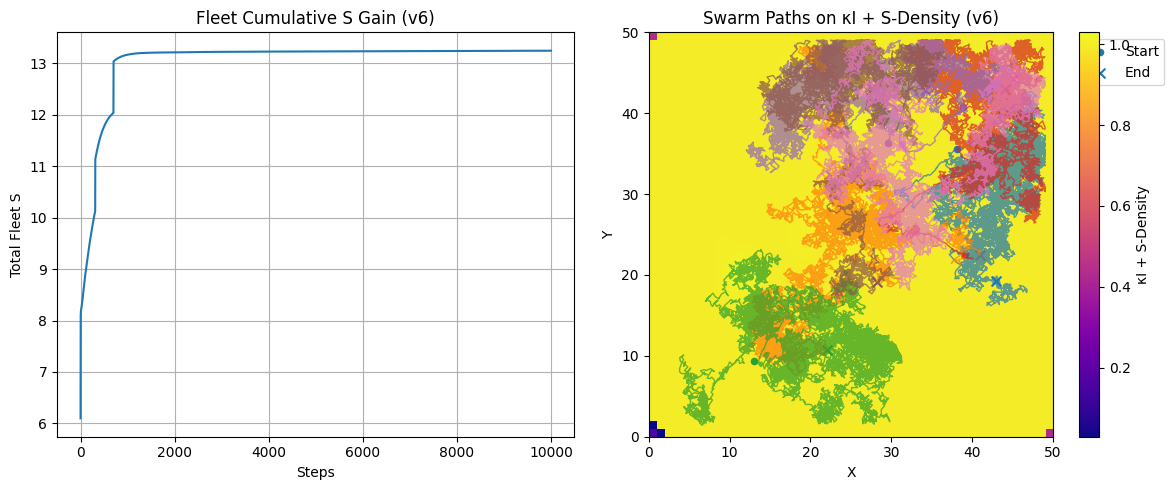

v6 Simulation complete. Final Fleet S: 13.248199727429947
v6 Final Coverage: 54.120000000000005 %


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# VDMField (unchanged)
class VDMField:
    def __init__(self, size=50, alpha=0.1, beta=0.1):
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.phi = np.random.uniform(-1, 1, (size, size))
        self.kappa = np.zeros((size, size))
        self.grad_phi = np.zeros((size, size, 2))
        self.i_field = np.zeros((size, size))
        self._compute_kappa_and_grad()
        self._compute_i()

    def _laplacian(self, phi):
        lap = np.zeros_like(phi)
        lap[1:-1, 1:-1] = (phi[2:, 1:-1] + phi[:-2, 1:-1] + phi[1:-1, 2:] + phi[1:-1, :-2] - 4 * phi[1:-1, 1:-1])
        return lap / 1.0

    def _gradient(self, phi):
        grad_x = np.zeros_like(phi)
        grad_y = np.zeros_like(phi)
        grad_x[1:, :] = (phi[1:, :] - phi[:-1, :])
        grad_y[:, 1:] = (phi[:, 1:] - phi[:, :-1])
        return np.stack([grad_x, grad_y], axis=-1)

    def _compute_kappa_and_grad(self):
        self.grad_phi = self._gradient(self.phi)
        grad_sq = np.sum(self.grad_phi**2, axis=-1)
        self.kappa = 1.0 / (1.0 + self.beta * grad_sq)

    def _compute_i(self):
        mean_n = np.zeros_like(self.phi)
        for dx, dy in [(0,1),(0,-1),(1,0),(-1,0)]:
            rolled = np.roll(self.phi, (dx, dy), axis=(0,1))
            mean_n += rolled
        mean_n /= 4.0
        prediction_error = np.abs(self.phi - mean_n)
        self.i_field = 1.0 / (1.0 + prediction_error)

    def evolve(self):
        lap = self._laplacian(self.phi)
        grad_sq = np.sum(self._gradient(self.phi)**2, axis=-1)
        delta_phi = self.alpha * lap + self.beta * grad_sq
        self.phi += delta_phi
        self.phi = np.clip(self.phi, -5, 5)
        self._compute_kappa_and_grad()
        self._compute_i()

    def get_ki_gradient_at(self, x, y):
        x, y = int(x), int(y)
        if not (0 <= x < self.size and 0 <= y < self.size):
            return np.zeros(2)
        ki = self.kappa * self.i_field
        dx = 0.0
        if x > 0 and x < self.size - 1:
            dx = (ki[x+1, y] - ki[x-1, y]) / 2.0
        elif x > 0:
            dx = ki[x-1, y] - ki[x, y]
        elif x < self.size - 1:
            dx = ki[x+1, y] - ki[x, y]

        dy = 0.0
        if y > 0 and y < self.size - 1:
            dy = (ki[x, y+1] - ki[x, y-1]) / 2.0
        elif y > 0:
            dy = ki[x, y-1] - ki[x, y]
        elif y < self.size - 1:
            dy = ki[x, y+1] - ki[x, y]

        return np.array([dx, dy])

# VDMAgent (v5 with energy)
class VDMAgent:
    def __init__(self, field, start_pos=(10,10), lambda_lyap=0.8, s0=1.0, agent_id=0, shared_s_map=None, bias_weight=0.1, epsilon=0.08):
        self.field = field
        self.shared_s_map = shared_s_map
        self.pos = np.array(start_pos, dtype=float)
        self.lambda_lyap = lambda_lyap
        self.s0 = s0
        self.agent_id = agent_id
        self.path = [start_pos]
        self.total_s = 0.0
        self.prev_i = 0.0
        self.color = plt.cm.tab10(agent_id % 10)
        self.bias_weight = bias_weight
        self.epsilon = epsilon
        self.energy = 20.0  # Tweaked initial

    def compute_delta_s(self):
        x, y = int(self.pos[0]), int(self.pos[1])
        if not (0 <= x < self.field.size and 0 <= y < self.field.size):
            return 0.0
        grad = self.field.grad_phi[x,y]
        delta_c = np.linalg.norm(grad)
        i_curr = self.field.i_field[x,y]
        delta_i = i_curr - self.prev_i
        self.prev_i = i_curr
        kappa = self.field.kappa[x,y]
        return delta_c + kappa * delta_i

    def get_map_bias(self, window_size=5):
        if self.shared_s_map is None:
            return np.zeros(2)
        x, y = int(self.pos[0]), int(self.pos[1])
        half_win = window_size // 2
        x_min, x_max = max(0, x - half_win), min(self.field.size, x + half_win + 1)
        y_min, y_max = max(0, y - half_win), min(self.field.size, y + half_win + 1)
        local_map = self.shared_s_map[x_min:x_max, y_min:y_max]
        if local_map.size == 0:
            return np.zeros(2)
        best_idx = np.unravel_index(np.argmax(local_map), local_map.shape)
        best_x, best_y = x_min + best_idx[0], y_min + best_idx[1]
        bias_vec = np.array([best_x - x, best_y - y])
        bias_mag = np.linalg.norm(bias_vec)
        if bias_mag > 0:
            return bias_vec / bias_mag * min(0.3, bias_mag)
        return np.zeros(2)

    def step(self, steps=1, other_agents=None, separation_dist=2.0):
        for _ in range(steps):
            x, y = int(self.pos[0]), int(self.pos[1])
            grad_ki = self.field.get_ki_gradient_at(x, y)
            grad_mag = np.linalg.norm(grad_ki)

            if grad_mag < 1e-6:
                s_move = np.random.uniform(-0.5, 0.5, 2)
            else:
                log_term = np.log(1 + grad_mag / self.s0)
                optimal_move = (2 / self.lambda_lyap) * log_term
                direction = grad_ki / grad_mag
                move_mag = max(0.1, min(1.0, optimal_move))
                s_move = direction * move_mag

            if np.random.rand() < self.epsilon:
                s_move += np.random.uniform(-0.3, 0.3, 2)
            else:
                map_bias = self.get_map_bias()
                s_move += self.bias_weight * map_bias

            separation = np.zeros(2)
            if other_agents:
                for other in other_agents:
                    if other.agent_id == self.agent_id: continue
                    dist_vec = self.pos - other.pos
                    dist = np.linalg.norm(dist_vec)
                    if dist < separation_dist and dist > 0:
                        separation += dist_vec / dist * (separation_dist - dist) / separation_dist

            total_move = s_move + 0.5 * separation
            self.pos += total_move
            self.pos = np.clip(self.pos, 0, self.field.size - 1)
            self.path.append(self.pos.copy())
            delta_s = self.compute_delta_s()
            self.total_s += max(0, delta_s)
            # v6: Recharge energy from ΔS
            self.energy += 0.01 * max(0, delta_s)
            self.energy = min(self.energy, 20.0)  # Cap at initial
            self.field.evolve()
        return self.total_s

# v6 Swarm: Energy harvest + avg energy check for spawn
class VDMSwarm:
    def __init__(self, field, n_agents=5, lambda_lyap=0.8, s0=1.0, bias_weight=0.1, epsilon=0.08):
        self.field = field
        self.agents = []
        self.shared_s_map = np.zeros((field.size, field.size))
        self.base_threshold = 2.0
        self.total_fleet_s = 0.0
        self.map_decay = 0.995
        self.cooldown = 0
        self.spawn_cost = 2.0

        starts = np.random.uniform(5, field.size-5, (n_agents, 2))
        for i, start in enumerate(starts):
            agent = VDMAgent(field, start, lambda_lyap, s0, i, self.shared_s_map, bias_weight, epsilon)
            agent.energy = 20.0
            self.agents.append(agent)

    def step(self, steps=1):
        dead_agents = []
        for i, agent in enumerate(self.agents):
            other_agents = [self.agents[j] for j in range(len(self.agents)) if j != i]
            agent.step(steps, other_agents)
            x, y = int(agent.pos[0]), int(agent.pos[1])
            self.shared_s_map[x, y] += agent.total_s * 0.01
            # Drain (tweaked low)
            agent.energy -= 0.001 * steps
            if agent.energy <= 0:
                dead_agents.append(i)

        for i in reversed(dead_agents):
            del self.agents[i]
            print(f"Agent {i} died (energy depleted). Fleet size now {len(self.agents)}")

        self.shared_s_map *= self.map_decay

        self.total_fleet_s = sum(a.total_s for a in self.agents)

        dynamic_threshold = self.base_threshold * len(self.agents)
        avg_energy = np.mean([a.energy for a in self.agents]) if self.agents else 0
        spawn_prob = 0.02 if self.cooldown > 100 else 0

        if (self.total_fleet_s > dynamic_threshold and
            len(self.agents) < 20 and
            np.random.rand() < spawn_prob and
            avg_energy > 12 and  # v6: Avg energy check
            any(a.energy > self.spawn_cost for a in self.agents)):
            new_start = np.mean([a.pos for a in self.agents], axis=0) + np.random.uniform(-3, 3, 2)
            new_agent = VDMAgent(self.field, new_start, agent_id=len(self.agents),
                                 shared_s_map=self.shared_s_map, bias_weight=self.agents[0].bias_weight,
                                 epsilon=self.agents[0].epsilon)
            new_agent.energy = 10.0  # Born full-ish
            richest = max(self.agents, key=lambda a: a.energy)
            richest.energy -= self.spawn_cost
            self.agents.append(new_agent)
            self.cooldown = 0
            print(f"Replication at fleet S={self.total_fleet_s:.2f} (thresh={dynamic_threshold:.1f}, avg E={avg_energy:.1f})! Size now {len(self.agents)}")
        else:
            self.cooldown += 1

        return self.total_fleet_s

    def get_coverage(self):
        explored = np.sum(self.shared_s_map > 0)
        return explored / self.shared_s_map.size * 100

# Demo
if __name__ == "__main__":
    np.random.seed(42)
    field = VDMField(size=50, alpha=0.1, beta=0.5)
    swarm = VDMSwarm(field, n_agents=5)

    total_steps = 10000
    fleet_s_gains = []
    coverages = []
    for t in range(total_steps):
        fleet_s = swarm.step(1)
        fleet_s_gains.append(fleet_s)
        coverages.append(swarm.get_coverage())
        if t % 1000 == 0:
            print(f"Step {t}: Fleet S = {fleet_s:.3f}, Coverage = {coverages[-1]:.1f}%, Size = {len(swarm.agents)}")

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(fleet_s_gains)
    axs[0].set_title('Fleet Cumulative S Gain (v6)')
    axs[0].set_xlabel('Steps')
    axs[0].set_ylabel('Total Fleet S')
    axs[0].grid(True)

    ki_map = field.kappa * field.i_field
    s_density = gaussian_filter(swarm.shared_s_map, sigma=1)
    im = axs[1].imshow(ki_map + s_density * 0.1, extent=[0,50,0,50], origin='lower', cmap='plasma')
    axs[1].set_title('Swarm Paths on κI + S-Density (v6)')

    legend_added = False
    for agent in swarm.agents:
        path_x, path_y = zip(*agent.path)
        axs[1].plot(path_x, path_y, '-', color=agent.color, alpha=0.7, linewidth=1)
        axs[1].scatter(path_x[0], path_y[0], color=agent.color, marker='o', s=20)
        axs[1].scatter(path_x[-1], path_y[-1], color=agent.color, marker='x', s=50)
        if not legend_added:
            axs[1].scatter([], [], color=agent.color, marker='o', s=20, label='Start')
            axs[1].scatter([], [], color=agent.color, marker='x', s=50, label='End')
            legend_added = True

    axs[1].set_xlabel('X')
    axs[1].set_ylabel('Y')
    plt.colorbar(im, ax=axs[1], label='κI + S-Density')
    axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig('vdm_swarm_v6.png')
    plt.show()
    print("v6 Simulation complete. Final Fleet S:", swarm.total_fleet_s)
    print("v6 Final Coverage:", swarm.get_coverage(), "%")

Step 0: Total S=1.305, Energy=20.00, Symbols=0
Step 200: Total S=10.620, Energy=20.00, Symbols=0
Step 400: Total S=10.686, Energy=20.00, Symbols=0
Step 600: Total S=10.860, Energy=20.00, Symbols=0
Step 800: Total S=11.172, Energy=20.00, Symbols=0
Final: Total S=11.455, Energy=20.00, Symbols last=0
Final position: [16.73399523 12.51929368]


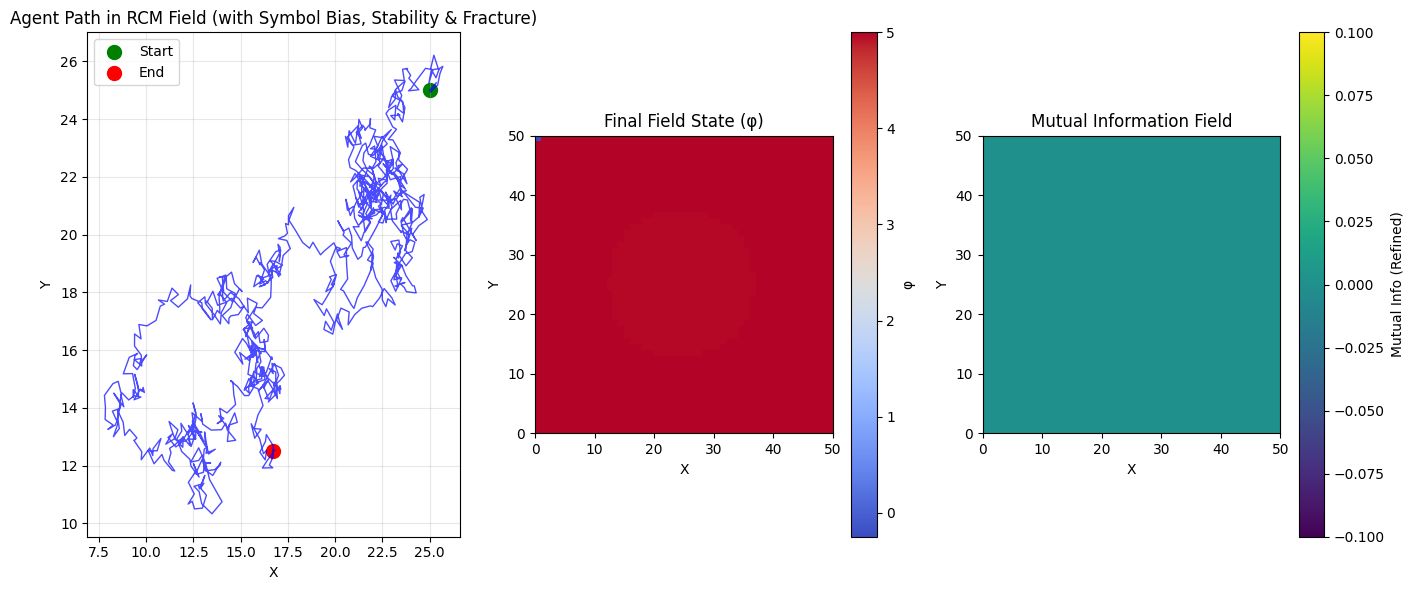


Summary: {'total_s': np.float64(11.454775029314078), 'energy': 20.0, 'symbol_count': 0, 'final_pos': array([16.73399523, 12.51929368]), 'path_length': 1001}


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi

class RCMField:
    def __init__(self, size=50, alpha=0.1, beta=0.5):
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.phi = np.random.uniform(-1, 1, (size, size))
        self.kappa = np.zeros((size, size))
        self.grad_phi = np.zeros((size, size, 2))
        self.i_field = np.zeros((size, size))
        self._update_field()

    def _laplacian(self, phi):
        lap = np.zeros_like(phi)
        lap[1:-1,1:-1] = (phi[2:,1:-1] + phi[:-2,1:-1] + phi[1:-1,2:] + phi[1:-1,:-2] - 4 * phi[1:-1,1:-1])
        return lap

    def _gradient(self, phi):
        grad_x = np.zeros_like(phi)
        grad_y = np.zeros_like(phi)
        grad_x[1:, :] = phi[1:, :] - phi[:-1, :]
        grad_y[:, 1:] = phi[:, 1:] - phi[:, :-1]
        return np.stack([grad_x, grad_y], axis=-1)

    def _local_mean(self, arr):
        mean_n = np.zeros_like(arr)
        for dx, dy in [(0,1),(0,-1),(1,0),(-1,0)]:
            mean_n += np.roll(np.roll(arr, dx, axis=0), dy, axis=1)
        return mean_n / 4.0

    def _compute_mutual_information(self):
        # Binned local MI: entropy of joint (phi_center, neigh_mean) vs. marginals on 3x3 patches
        mi = np.zeros_like(self.phi)
        bins = 10  # Coarse for speed
        bin_edges = np.linspace(-5, 5, bins + 1)
        for i in range(1, self.size - 1):
            for j in range(1, self.size - 1):
                patch = self.phi[i-1:i+2, j-1:j+2].flatten()
                center = self.phi[i, j]
                neigh_mean = np.mean(patch[patch != center])  # Exclude center

                # Binned histograms (single points, so sparse)
                joint_hist, _, _ = np.histogram2d([center], [neigh_mean], bins=[bin_edges, bin_edges])
                marg_center, _ = np.histogram([center], bins=bin_edges)
                marg_neigh, _ = np.histogram([neigh_mean], bins=bin_edges)

                # Entropies (add epsilon for log stability)
                eps = 1e-10
                h_joint = -np.sum(joint_hist * np.log(joint_hist + eps))
                h_marg_c = -np.sum(marg_center * np.log(marg_center + eps))
                h_marg_n = -np.sum(marg_neigh * np.log(marg_neigh + eps))

                mi[i, j] = max(0, h_marg_c + h_marg_n - h_joint)  # MI >=0

        # Extrapolate borders simply
        mi[0, :] = mi[1, :]
        mi[-1, :] = mi[-2, :]
        mi[:, 0] = mi[:, 1]
        mi[:, -1] = mi[:, -2]
        return np.clip(mi / np.max(mi + 1e-10), 0, 1)  # Normalize to [0,1]

    def _update_field(self):
        self.grad_phi = self._gradient(self.phi)
        grad_sq = np.sum(self.grad_phi**2, axis=-1)
        self.kappa = 1.0 / (1.0 + self.beta * grad_sq)
        self.i_field = self._compute_mutual_information()

    def evolve(self):
        lap = self._laplacian(self.phi)
        grad_sq = np.sum(self.grad_phi**2, axis=-1)
        delta_phi = self.alpha * lap + self.beta * grad_sq
        self.phi += delta_phi
        self.phi = np.clip(self.phi, -5, 5)
        self._update_field()

class SymbolExtractorRCM:
    def __init__(self, field, threshold=0.8, max_symbols=10, stability_window=50, stability_tol=1.0):
        self.field = field
        self.threshold = threshold
        self.max_symbols = max_symbols
        self.stability_window = stability_window
        self.stability_tol = stability_tol
        self.symbols = []
        self.recent_states = []  # Rolling buffer of recent symbolic states (centroids)

    def detect_symbols(self):
        high_info = self.field.i_field > self.threshold
        labeled, num_features = ndi.label(high_info)
        new_symbols = []
        for symbol_id in range(1, num_features + 1):
            coords = np.argwhere(labeled == symbol_id)
            if coords.size == 0: continue
            centroid = coords.mean(axis=0)
            avg_kappa = np.mean(self.field.kappa[labeled == symbol_id])
            avg_grad = np.mean(np.linalg.norm(self.field.grad_phi[labeled == symbol_id], axis=-1))
            size = coords.shape[0]

            # Compute stability score: fraction of recent states with a centroid within tol
            stability_score = 0.0
            if self.recent_states:
                state_matches = 0
                for state in self.recent_states:
                    if state:
                        state_cents = np.array([list(v['centroid']) for v in state.values()])
                        if len(state_cents) > 0 and np.any(np.linalg.norm(state_cents - centroid, axis=1) < self.stability_tol):
                            state_matches += 1
                stability_score = state_matches / len(self.recent_states)

            # Fracture metric: Deviation of symbol's internal flow from local field mean
            # (e.g., how much its avg |∇φ| exceeds the 5x5 surrounding field's mean—quantifies "break" from continuum)
            cx, cy = int(centroid[0]), int(centroid[1])
            if 2 <= cx <= self.field.size - 3 and 2 <= cy <= self.field.size - 3:
                local_grad_mag = np.mean(np.linalg.norm(self.field.grad_phi[cx-2:cx+3, cy-2:cy+3], axis=-1))
                internal_grad_mag = np.linalg.norm(self.field.grad_phi[cx, cy])  # Proxy for symbol core flow
                fracture_score = max(0, (internal_grad_mag - local_grad_mag) / (local_grad_mag + 1e-8))  # Normalized rupture [0,∞)
            else:
                fracture_score = 0.0

            symbol_desc = {
                'id': symbol_id,
                'centroid': centroid,
                'avg_kappa': avg_kappa,
                'avg_grad': avg_grad,
                'size': size,
                'stability': stability_score,
                'fracture': fracture_score
            }
            new_symbols.append(symbol_desc)

        # Sort by (kappa * grad * size * (1 + stability) * (1 + fracture)), reverse=True—favor breaks that persist
        new_symbols.sort(key=lambda s: s['avg_kappa'] * s['avg_grad'] * s['size'] * (1 + s['stability']) * (1 + s['fracture']), reverse=True)
        self.symbols = new_symbols[:self.max_symbols]

        # Update recent states buffer (append current state, keep last window)
        current_state = self.get_symbolic_state()
        self.recent_states.append(current_state)
        if len(self.recent_states) > self.stability_window:
            self.recent_states.pop(0)

    def get_symbolic_state(self):
        return {s['id']: {k: v for k, v in s.items() if k != 'id'} for s in self.symbols}

class RCMAgentWithSymbolicReasoning:
    def __init__(self, field, start_pos=(25,25), lambda_lyap=0.8, s0=1.0, energy=20.0):
        self.field = field
        self.pos = np.array(start_pos, dtype=float)
        self.lambda_lyap = lambda_lyap
        self.s0 = s0
        self.energy = energy
        self.prev_i = 0.0
        self.path = [tuple(start_pos)]
        self.total_s = 0.0
        self.symbol_extractor = SymbolExtractorRCM(field)

    def get_ki_gradient(self):
        x,y = int(self.pos[0]), int(self.pos[1])
        size = self.field.size
        if not (0 <= x < size and 0 <= y < size):
            return np.zeros(2)
        ki = self.field.kappa * self.field.i_field
        grad_x = 0
        grad_y = 0
        if 0 < x < size-1:
            grad_x = (ki[x+1,y] - ki[x-1,y]) / 2
        elif x > 0:
            grad_x = ki[x,y] - ki[x-1,y]
        elif x < size - 1:
            grad_x = ki[x+1,y] - ki[x,y]
        if 0 < y < size-1:
            grad_y = (ki[x,y+1] - ki[x,y-1]) / 2
        elif y > 0:
            grad_y = ki[x,y] - ki[x,y-1]
        elif y < size - 1:
            grad_y = ki[x,y+1] - ki[x,y]
        return np.array([grad_x, grad_y])

    def compute_delta_s(self):
        x,y = int(self.pos[0]), int(self.pos[1])
        grad = self.field.grad_phi[x,y]
        delta_c = np.linalg.norm(grad)
        i_curr = self.field.i_field[x,y]
        delta_i = i_curr - self.prev_i
        self.prev_i = i_curr
        kappa = self.field.kappa[x,y]
        return delta_c + kappa * delta_i

    def step(self):
        grad_ki = self.get_ki_gradient()
        grad_norm = np.linalg.norm(grad_ki)
        if grad_norm < 1e-8:
            move_vec = np.random.uniform(-0.5,0.5,2)
        else:
            log_term = np.log(1 + grad_norm / self.s0)
            move_mag = max(0.1, min(1.0, (2 / self.lambda_lyap) * log_term))
            move_vec = grad_ki / grad_norm * move_mag
        move_vec += np.random.normal(0,0.05,2)

        # Bias move_vec towards nearest symbol centroid if close enough
        if self.symbol_extractor.symbols:
            pos = self.pos
            closest_sym = min(self.symbol_extractor.symbols,
                              key=lambda s: np.linalg.norm(pos - s['centroid']))
            dist = np.linalg.norm(pos - closest_sym['centroid'])
            if dist < 5.0:
                bias_vec = closest_sym['centroid'] - pos
                bias_vec /= np.linalg.norm(bias_vec) + 1e-8
                move_vec += 0.2 * bias_vec  # small bias weight

        self.pos += move_vec
        self.pos = np.clip(self.pos, 0, self.field.size - 1)
        self.path.append(tuple(self.pos))
        delta_s = self.compute_delta_s()
        self.total_s += max(0, delta_s)
        self.energy += 0.01 * max(0, delta_s)
        self.energy = min(self.energy, 20.0)
        self.field.evolve()

        # Symbolic reasoning update
        self.symbol_extractor.detect_symbols()
        symbolic_state = self.symbol_extractor.get_symbolic_state()
        # For now, just store symbolic states - future: use for decision making
        if not hasattr(self, 'symbolic_memory'):
            self.symbolic_memory = []
        self.symbolic_memory.append(symbolic_state)

        return delta_s

    def is_alive(self):
        return self.energy > 0

def main(steps=1000, plot=True):
    np.random.seed(42)
    field = RCMField(size=50, alpha=0.1, beta=0.5)
    agent = RCMAgentWithSymbolicReasoning(field, start_pos=(25,25))

    for step in range(steps):
        delta_s = agent.step()
        if not agent.is_alive():
            print(f"Agent energy depleted at step {step}")
            break
        if step % 200 == 0:
            print(f"Step {step}: Total S={agent.total_s:.3f}, Energy={agent.energy:.2f}, Symbols={len(agent.symbol_extractor.symbols)}")

    print(f"Final: Total S={agent.total_s:.3f}, Energy={agent.energy:.2f}, Symbols last={len(agent.symbol_extractor.symbols)}")
    print(f"Final position: {agent.pos}")

    # Print stability and fracture of final symbols
    for sym in agent.symbol_extractor.symbols:
        print(f"Final symbol stability: {sym['stability']:.3f}, fracture: {sym['fracture']:.3f}")

    if plot:
        path = np.array(agent.path)
        plt.figure(figsize=(14,6))

        plt.subplot(1,3,1)
        plt.plot(path[:,0], path[:,1], 'b-', alpha=0.7, linewidth=1)
        plt.scatter(path[0,0], path[0,1], color='green', s=100, label='Start')
        plt.scatter(path[-1,0], path[-1,1], color='red', s=100, label='End')
        plt.title('Agent Path in RCM Field (with Symbol Bias, Stability & Fracture)')
        plt.xlabel('X'); plt.ylabel('Y'); plt.legend(); plt.grid(True, alpha=0.3)

        plt.subplot(1,3,2)
        plt.imshow(field.phi, cmap='coolwarm', extent=[0, field.size, 0, field.size])
        plt.colorbar(label='φ')
        plt.title('Final Field State (φ)')
        plt.xlabel('X'); plt.ylabel('Y')

        plt.subplot(1,3,3)
        i_field = field.i_field
        plt.imshow(i_field, cmap='viridis', extent=[0, field.size, 0, field.size])
        plt.colorbar(label='Mutual Info (Refined)')
        plt.title('Mutual Information Field')
        plt.xlabel('X'); plt.ylabel('Y')

        # Overlay detected symbols as circles, sized by (stability + fracture)
        for sym in agent.symbol_extractor.symbols:
            c = sym['centroid']
            size = sym['size']
            radius = np.sqrt(size)/2 * (1 + sym['stability'] + sym['fracture'])  # Scale by combined distinction
            plt.gca().add_patch(plt.Circle((c[1], c[0]), radius, fill=False, color='red', linewidth=2))

        plt.tight_layout()
        plt.show()

    return {
        'total_s': agent.total_s,
        'energy': agent.energy,
        'symbol_count': len(agent.symbol_extractor.symbols),
        'final_pos': agent.pos,
        'path_length': len(agent.path)
    }

# Run initial test
if __name__ == "__main__":
    results = main()
    print("\nSummary:", results)

In [ ]:
!pip install qutip

In [ ]:
import numpy as np
from qutip import Qobj, tensor, sigmax, sigmaz, sigmap, sigmam, mesolve, qeye, ptrace, entropy_vn

# Parameters
n_qubits = 3  # Small chain for tractability
alpha = 1.0   # Diffusion (dephasing rate proxy)
beta = 0.05   # Nonlinearity (damping strength)
kappa = 0.5
gamma = [0.01, 0.1, 0.5]  # Decoherence sweep: low (coherent) to high (classical)
steps = 100
agent_qubit = 1  # Agent "observes" central qubit

# Initial state: Central excitation (coherent superposition)
psi0 = tensor([qeye(2)] * (agent_qubit) + [sigmap()] + [qeye(2)] * (n_qubits - agent_qubit - 1))
rho0 = psi0 * psi0.dag()
rho0 = rho0 / rho0.tr()  # Normalize density matrix

# Hamiltonian: 1D hopping (diffusion) + local fields (nonlinearity proxy)
def hamiltonian(n):
    H = tensor([qeye(2)] * n) * 0.0  # Initialize zero with proper dims
    for i in range(n):
        ops = [qeye(2)] * n
        ops[i] = sigmaz()
        H += tensor(ops)  # Local Z fields
        if i < n-1:
            ops1 = [qeye(2)] * n
            ops2 = [qeye(2)] * n
            ops1[i] = sigmax()
            ops2[i+1] = sigmax()
            H += 0.5 * alpha * tensor(ops1) * tensor(ops2)  # Hopping
    # Nonlinear: interaction between first two qubits
    ops_z = [qeye(2)] * n
    ops_z[0] = sigmaz()
    ops_x = [qeye(2)] * n
    ops_x[1] = sigmax()
    H += beta * tensor(ops_z) * tensor(ops_x)
    return H

H = hamiltonian(n_qubits)

# Collapse operators: Dephasing (alpha-diffusion) + Amplitude damping (beta-nonlinearity)
c_ops_base = []
for i in range(n_qubits):
    ops = [qeye(2)] * n_qubits
    ops[i] = sigmaz()
    c_ops_base.append(np.sqrt(alpha) * tensor(ops))  # Dephasing
    ops[i] = sigmam()
    c_ops_base.append(np.sqrt(beta) * tensor(ops))  # Damping

# Quantum C: Gradient of von Neumann entropy across chain
def quantum_C(rho):
    S_local = []
    for i in range(n_qubits):
        rho_i = ptrace(rho, [i])
        S_i = entropy_vn(rho_i)  # vN entropy (nats; relative scaling fine)
        S_local.append(S_i)
    grad_S = np.diff(S_local, prepend=0)  # Simple gradient
    return np.sum(np.abs(grad_S))

# Quantum I: Mutual information between agent qubit and neighbors
def quantum_I(rho, agent):
    rho_A = ptrace(rho, [agent])
    S_A = entropy_vn(rho_A)
    if agent == 0:
        neighbors = [1]
    elif agent == n_qubits - 1:
        neighbors = [agent-1]
    else:
        neighbors = [agent-1, agent+1]
    rho_B = ptrace(rho, neighbors)
    S_B = entropy_vn(rho_B)
    S_AB = entropy_vn(rho)  # Full joint
    return S_A + S_B - S_AB  # MI

# S = C + kappa * I
def quantum_S(rho):
    return quantum_C(rho) + kappa * quantum_I(rho, agent_qubit)

# Agent action: Evolve forward, choose basis maximizing projected S
def agent_action(rho, dt, g):
    times = [0, dt]
    c_ops = [np.sqrt(g) * op for op in c_ops_base]
    result = mesolve(H, rho, times, c_ops=c_ops, progress_bar=False)
    next_rho = result.states[-1]

    # Candidates: Z (default) vs. X rotation on agent
    S_Z = quantum_S(next_rho)
    X_op = tensor([sigmax() if i==agent_qubit else qeye(2) for i in range(n_qubits)])
    rho_X = X_op * next_rho * X_op.dag()  # Unitary "probe"
    rho_X = rho_X / rho_X.tr()
    S_X = quantum_S(rho_X)

    best_action = 'Z' if S_Z > S_X else 'X'
    return best_action, next_rho  # Use default evolution for continuity

# Run sweep
dt = 0.1
results = {g: {'S_history': [], 'symbol_persistence': [], 'actions': []} for g in gamma}
for g in gamma:
    rho = rho0.copy()
    S_hist = [quantum_S(rho)]
    persist = []
    actions = []
    for t in range(steps):
        action, rho = agent_action(rho, dt, g)
        actions.append(action)
        S = quantum_S(rho)
        S_hist.append(S)
        fid = (rho * rho0).tr().real
        persist.append(fid)
    results[g]['S_history'] = S_hist
    results[g]['symbol_persistence'] = np.mean(persist[-10:])
    results[g]['actions'] = actions

# Output summary
for g in gamma:
    print(f'Gamma={g}: Avg S={np.mean(results[g]["S_history"]):.3f}, Late Persistence={results[g]["symbol_persistence"]:.3f}')
    print(f'  Action bias (Z fraction): {np.mean([a=="Z" for a in results[g]["actions"]]):.2f}')
    print()

/usr/local/lib/python3.12/dist-packages/qutip/solver/solver_base.py:486: FutureWarning: "progress_bar" is now included in options:
 Use `options={"progress_bar": False / True / "tqdm" / "enhanced"}`
  warnings.warn(


Gamma=0.01: Avg S=1.167, Late Persistence=0.207
  Action bias (Z fraction): 0.42

Gamma=0.1: Avg S=0.847, Late Persistence=0.152
  Action bias (Z fraction): 0.35

Gamma=0.5: Avg S=0.815, Late Persistence=0.119
  Action bias (Z fraction): 0.30



Feedback Gamma=0.01: Avg S=0.838, Late Persistence=0.126
  Action bias (Z fraction): 0.37
  Avg g late: 2.000

Feedback Gamma=0.1: Avg S=0.854, Late Persistence=0.124
  Action bias (Z fraction): 0.41
  Avg g late: 2.000

Feedback Gamma=0.5: Avg S=0.867, Late Persistence=0.126
  Action bias (Z fraction): 0.38
  Avg g late: 2.000



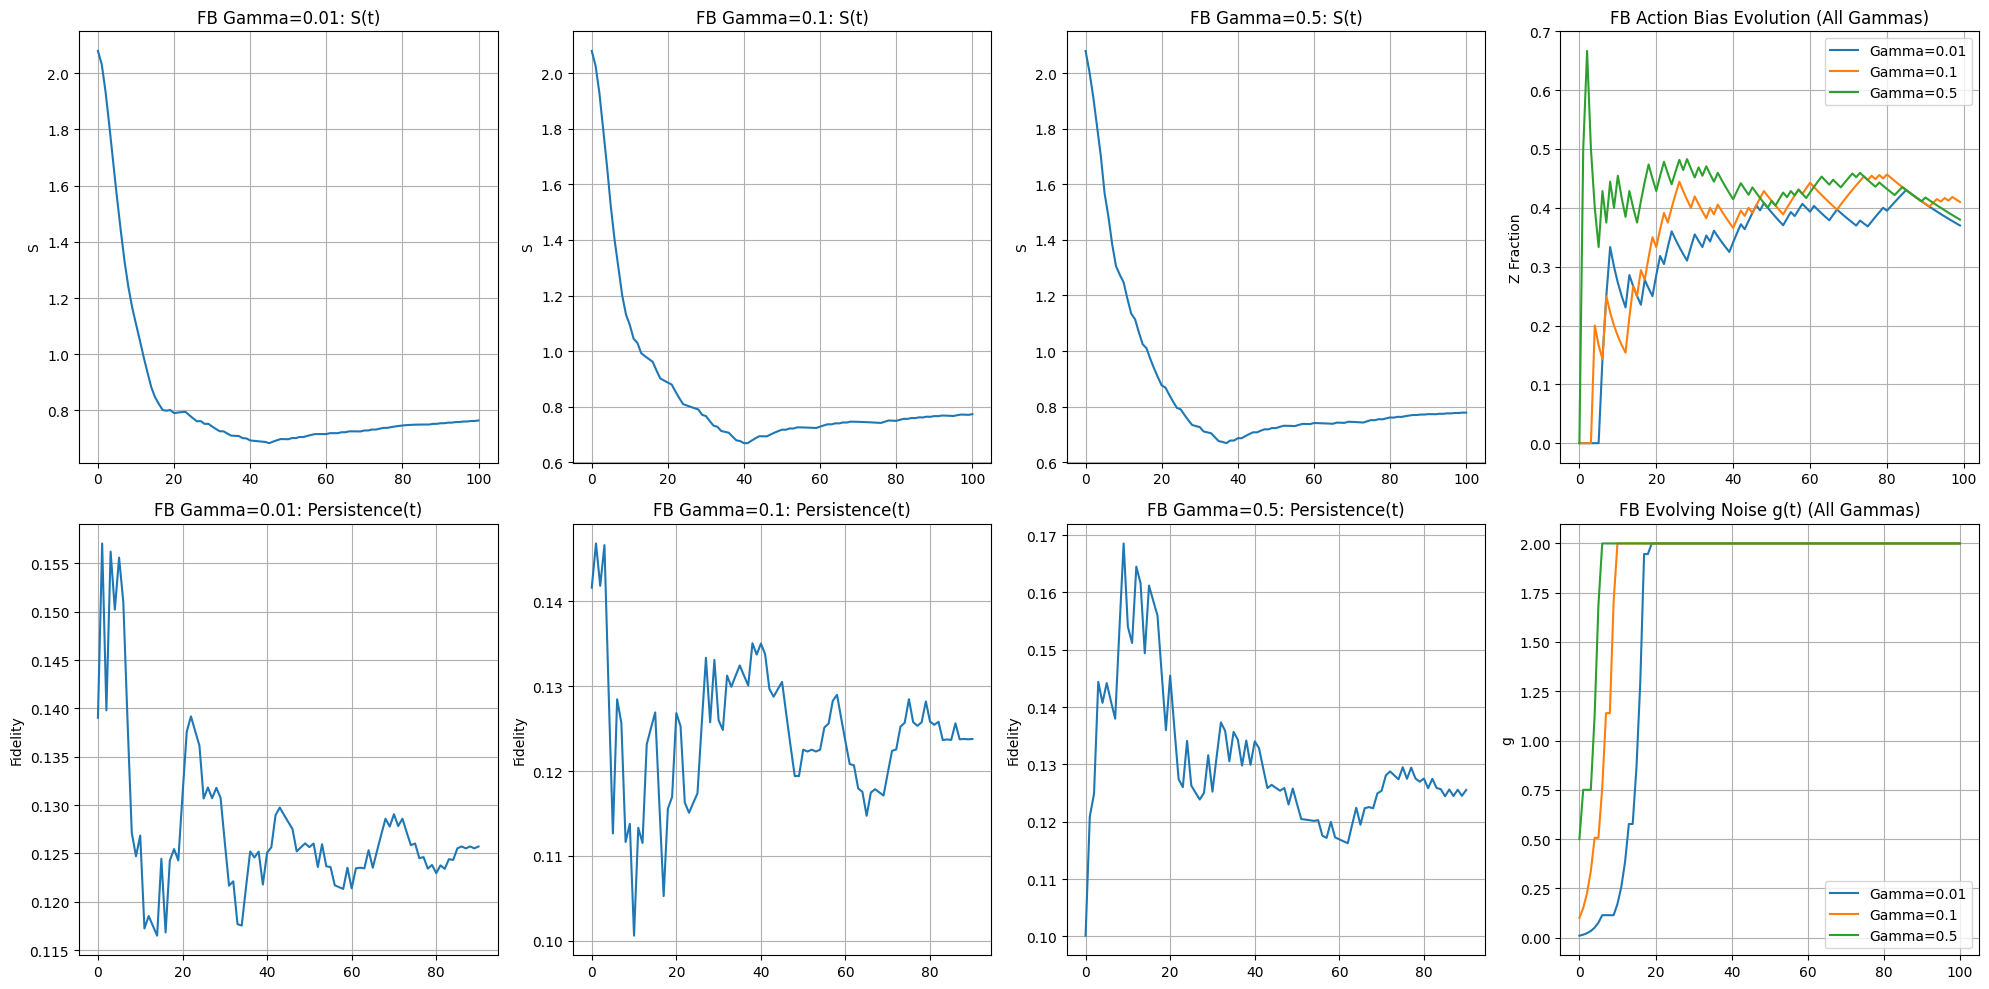

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import Qobj, tensor, sigmax, sigmaz, sigmap, sigmam, mesolve, qeye, ptrace, entropy_vn, Options

# Parameters
n_qubits = 3  # Small chain for tractability
alpha = 1.0   # Diffusion (dephasing rate proxy)
beta = 0.05   # Nonlinearity (damping strength)
kappa = 0.5
gamma = [0.01, 0.1, 0.5]  # Decoherence sweep: low (coherent) to high (classical)
steps = 100
agent_qubit = 1  # Agent "observes" central qubit

# Initial state: Central excitation (coherent superposition)
psi0 = tensor([qeye(2)] * (agent_qubit) + [sigmap()] + [qeye(2)] * (n_qubits - agent_qubit - 1))
rho0 = psi0 * psi0.dag()
rho0 = rho0 / rho0.tr()  # Normalize density matrix

# Hamiltonian: 1D hopping (diffusion) + local fields (nonlinearity proxy)
def hamiltonian(n):
    H = tensor([qeye(2)] * n) * 0.0  # Initialize zero with proper dims
    for i in range(n):
        ops = [qeye(2)] * n
        ops[i] = sigmaz()
        H += tensor(ops)  # Local Z fields
        if i < n-1:
            ops1 = [qeye(2)] * n
            ops2 = [qeye(2)] * n
            ops1[i] = sigmax()
            ops2[i+1] = sigmax()
            H += 0.5 * alpha * tensor(ops1) * tensor(ops2)  # Hopping
    # Nonlinear: interaction between first two qubits
    ops_z = [qeye(2)] * n
    ops_z[0] = sigmaz()
    ops_x = [qeye(2)] * n
    ops_x[1] = sigmax()
    H += beta * tensor(ops_z) * tensor(ops_x)
    return H

H = hamiltonian(n_qubits)

# Collapse operators: Dephasing (alpha-diffusion) + Amplitude damping (beta-nonlinearity)
c_ops_base = []
for i in range(n_qubits):
    ops = [qeye(2)] * n_qubits
    ops[i] = sigmaz()
    c_ops_base.append(np.sqrt(alpha) * tensor(ops))  # Dephasing
    ops[i] = sigmam()
    c_ops_base.append(np.sqrt(beta) * tensor(ops))  # Damping

# Solver options to handle stiffness
opts = Options(nsteps=10000)  # Bump steps to avoid "excess work" error

# Quantum C: Gradient of von Neumann entropy across chain
def quantum_C(rho):
    S_local = []
    for i in range(n_qubits):
        rho_i = ptrace(rho, [i])
        S_i = entropy_vn(rho_i)  # vN entropy (nats; relative scaling fine)
        S_local.append(S_i)
    grad_S = np.diff(S_local, prepend=0)  # Simple gradient
    return np.sum(np.abs(grad_S))

# Quantum I: Mutual information between agent qubit and neighbors
def quantum_I(rho, agent):
    rho_A = ptrace(rho, [agent])
    S_A = entropy_vn(rho_A)
    if agent == 0:
        neighbors = [1]
    elif agent == n_qubits - 1:
        neighbors = [agent-1]
    else:
        neighbors = [agent-1, agent+1]
    rho_B = ptrace(rho, neighbors)
    S_B = entropy_vn(rho_B)
    S_AB = entropy_vn(rho)  # Full joint
    return S_A + S_B - S_AB  # MI

# S = C + kappa * I
def quantum_S(rho):
    return quantum_C(rho) + kappa * quantum_I(rho, agent_qubit)

# Enhanced agent action with feedback
def agent_action_feedback(rho, dt, current_g):
    times = [0, dt]
    c_ops = [np.sqrt(current_g) * op for op in c_ops_base]
    result = mesolve(H, rho, times, c_ops=c_ops, options=opts, progress_bar=False)
    next_rho = result.states[-1]

    S_Z = quantum_S(next_rho)
    X_op = tensor([sigmax() if i==agent_qubit else qeye(2) for i in range(n_qubits)])
    rho_X = X_op * next_rho * X_op.dag()
    rho_X = rho_X / rho_X.tr()
    S_X = quantum_S(rho_X)

    best_action = 'Z' if S_Z > S_X else 'X'

    if best_action == 'X':
        next_rho = rho_X  # Enact unitary probe
        g_next = min(current_g * 1.5, 2.0)  # Noise penalty, capped to prevent runaway
    else:
        g_next = current_g  # Hold steady

    return best_action, next_rho, g_next

# Updated sweep loop
dt = 0.1
results_fb = {g: {'S_history': [], 'symbol_persistence': [], 'actions': [], 'g_history': []} for g in gamma}
for g in gamma:
    rho = rho0.copy()
    current_g = g
    S_hist = [quantum_S(rho)]
    persist = []
    actions = []
    g_hist = [current_g]
    for t in range(steps):
        action, rho, current_g = agent_action_feedback(rho, dt, current_g)
        actions.append(action)
        S = quantum_S(rho)
        S_hist.append(S)
        fid = (rho * rho0).tr().real
        persist.append(fid)
        g_hist.append(current_g)
    results_fb[g]['S_history'] = S_hist
    results_fb[g]['symbol_persistence'] = persist
    results_fb[g]['actions'] = actions
    results_fb[g]['g_history'] = g_hist

# Quick summary for feedback run
for g in gamma:
    print(f'Feedback Gamma={g}: Avg S={np.mean(results_fb[g]["S_history"]):.3f}, Late Persistence={np.mean(results_fb[g]["symbol_persistence"][-10:]):.3f}')
    print(f'  Action bias (Z fraction): {np.mean([a=="Z" for a in results_fb[g]["actions"]]):.2f}')
    print(f'  Avg g late: {np.mean(results_fb[g]["g_history"][-10:]):.3f}')
    print()

# Plot extension for feedback results
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
gammas = gamma

for idx, g in enumerate(gammas):
    data = results_fb[g]

    # S_history
    axs[0, idx].plot(data['S_history'])
    axs[0, idx].set_title(f'FB Gamma={g}: S(t)')
    axs[0, idx].set_ylabel('S')
    axs[0, idx].grid(True)

    # Persistence: rolling mean fidelity over window=10
    persist_rolling = np.convolve(data['symbol_persistence'], np.ones(10)/10, mode='valid')
    axs[1, idx].plot(persist_rolling)
    axs[1, idx].set_title(f'FB Gamma={g}: Persistence(t)')
    axs[1, idx].set_ylabel('Fidelity')
    axs[1, idx].grid(True)

# Actions: cumulative Z fraction (overlay)
axs[0, 3].clear()
for g_val in gammas:
    data = results_fb[g_val]
    z_cum = np.cumsum([a == 'Z' for a in data['actions']]) / (np.arange(len(data['actions'])) + 1)
    axs[0, 3].plot(z_cum, label=f'Gamma={g_val}')
axs[0, 3].set_title('FB Action Bias Evolution (All Gammas)')
axs[0, 3].set_ylabel('Z Fraction')
axs[0, 3].legend()
axs[0, 3].grid(True)

# g_history (overlay on one plot)
axs[1, 3].clear()
for g_val in gammas:
    g_data = results_fb[g_val]['g_history']
    axs[1, 3].plot(g_data, label=f'Gamma={g_val}')
axs[1, 3].set_title('FB Evolving Noise g(t) (All Gammas)')
axs[1, 3].set_ylabel('g')
axs[1, 3].legend()
axs[1, 3].grid(True)

plt.tight_layout()
plt.savefig('quantum_rcm_feedback.png')  # Optional export
plt.show()

/usr/local/lib/python3.12/dist-packages/qutip/solver/solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Final p_fw: 0.9966
Final p_ctc: 0.0034
Final |coherence|: 0.0410


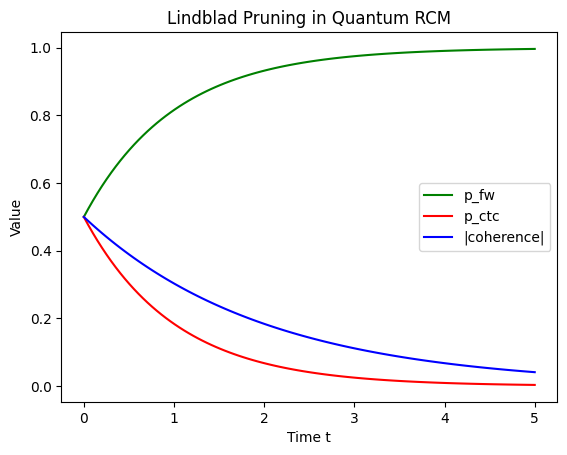

In [ ]:
import qutip as qt
import numpy as np

# Parameters
gamma = 1.0  # Decoherence rate
tlist = np.linspace(0, 5, 100)  # Time points

# Basis states: |0> = fw (causal), |1> = ctc
psi0 = qt.basis(2, 0)
psi1 = qt.basis(2, 1)
Psi0 = (psi0 + psi1).unit()  # Initial equal superposition

# Initial density matrix
rho0 = Psi0 * Psi0.dag()

# Hamiltonian (0 for pure decoherence; add H = C + kappa I for full RCM)
H = 0 * qt.num(2)

# Lindblad operator: sqrt(gamma) * |0><1| (damps CTC to fw)
L = np.sqrt(gamma) * (psi0 * psi1.dag())

# Solve master equation
result = qt.mesolve(H, rho0, tlist, [L], [])

# Extract data
p_fw = [qt.expect(psi0 * psi0.dag(), state) for state in result.states]
p_ctc = [qt.expect(psi1 * psi1.dag(), state) for state in result.states]
coherence = [state[0, 1] for state in result.states]  # rho[0,1] off-diagonal

# Outputs (e.g., finals)
print(f"Final p_fw: {p_fw[-1]:.4f}")
print(f"Final p_ctc: {p_ctc[-1]:.4f}")
print(f"Final |coherence|: {np.abs(coherence[-1]):.4f}")

# Plot (optional)
import matplotlib.pyplot as plt
plt.plot(tlist, p_fw, label='p_fw', color='green')
plt.plot(tlist, p_ctc, label='p_ctc', color='red')
plt.plot(tlist, np.abs(coherence), label='|coherence|', color='blue')
plt.xlabel('Time t')
plt.ylabel('Value')
plt.legend()
plt.title('Lindblad Pruning in Quantum RCM')
plt.show()

/usr/local/lib/python3.12/dist-packages/qutip/solver/solver_base.py:583: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Final p_fw: 0.9966
Final p_ctc: 0.0034
Final |coherence|: 0.0410


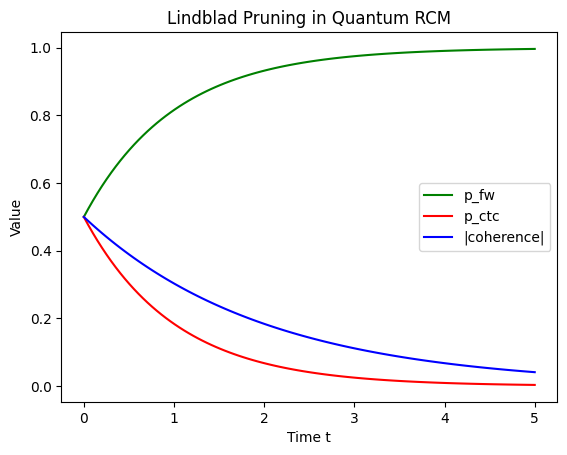

In [ ]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 1.0  # Decoherence rate
tlist = np.linspace(0, 5, 100)  # Time points

# Basis states: |0> = fw (causal), |1> = ctc
psi0 = qt.basis(2, 0)
psi1 = qt.basis(2, 1)
Psi0 = (psi0 + psi1).unit()  # Initial equal superposition

# Initial density matrix
rho0 = Psi0 * Psi0.dag()

# Hamiltonian (0 for pure decoherence; add H = C + kappa I for full RCM)
H = 0 * qt.num(2)

# Lindblad operator: sqrt(gamma) * |0><1| (damps CTC to fw)
L = np.sqrt(gamma) * (psi0 * psi1.dag())

# Solve master equation
result = qt.mesolve(H, rho0, tlist, [L], [])

# Extract data
p_fw = [qt.expect(psi0 * psi0.dag(), state) for state in result.states]
p_ctc = [qt.expect(psi1 * psi1.dag(), state) for state in result.states]
coherence = [state[0, 1] for state in result.states]  # rho[0,1] off-diagonal

# Outputs (e.g., finals)
print(f"Final p_fw: {p_fw[-1]:.4f}")
print(f"Final p_ctc: {p_ctc[-1]:.4f}")
print(f"Final |coherence|: {np.abs(coherence[-1]):.4f}")

# Plot
plt.plot(tlist, p_fw, label='p_fw', color='green')
plt.plot(tlist, p_ctc, label='p_ctc', color='red')
plt.plot(tlist, np.abs(coherence), label='|coherence|', color='blue')
plt.xlabel('Time t')
plt.ylabel('Value')
plt.legend()
plt.title('Lindblad Pruning in Quantum RCM')
plt.show()

Evolving field with true mutual information for ΔI...

=== RCM Wave Propagation Results (with True MI for ΔI) ===
Fitted linear speed c: 0.045 (lattice units)
Theoretical bound sqrt(α): 1.000
Physical linear c (× dx): 0.003
Linear fit R²: 0.917

Fitted diffusion coeff D: 0.019
Physical D (× dx²): 0.000
Sqrt fit R²: 0.913

Final S proxy (C + κ I): 5.884 (C=0.022, κI=5.862)
Average MI over run: 0.852
Final MI: 0.933
Final φ std: 0.211


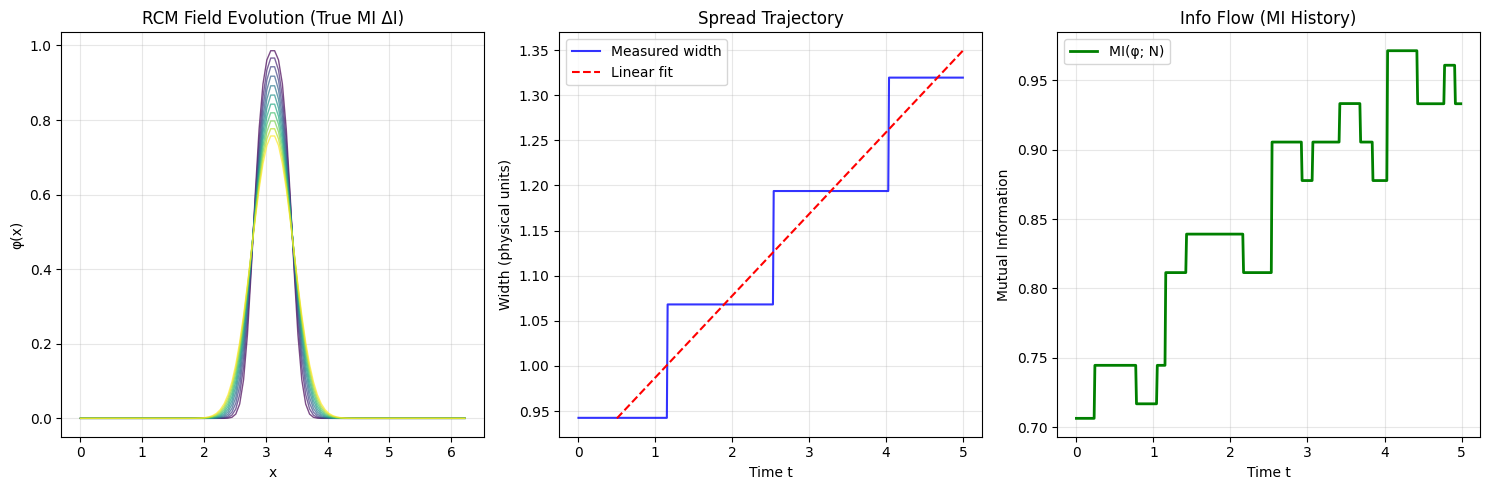

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress
from scipy.stats import entropy

# Tunable Parameters
N = 100  # lattice sites (increase for better resolution)
alpha = 1.0  # stiffness parameter (diffusion-like coefficient)
beta = 0.1  # damping strength in kappa = 1/(1 + beta * |grad|^2)
eta = 0.5  # strength of info drive
dt = 0.01  # time step (smaller for stability)
steps = 500  # total evolution steps
dx = 2 * np.pi / N  # physical spacing (periodic domain [0, 2pi])
plot_interval = 50  # plot every N steps
bins_mi = 10  # bins for mutual information histogram
renorm_threshold = 2.0  # renorm if std > this

def mutual_info(x, y, bins=10):
    """Compute mutual information MI(X;Y) = H(X) + H(Y) - H(X,Y) using histogram approximation."""
    if len(x) == 0:
        return 0.0
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    if x_max == x_min or y_max == y_min:
        return 0.0
    x_edges = np.linspace(x_min, x_max, bins + 1)
    y_edges = np.linspace(y_min, y_max, bins + 1)
    x_binned = np.digitize(x, x_edges) - 1  # 0 to bins-1
    y_binned = np.digitize(y, y_edges) - 1

    # Joint histogram (normalized to probabilities)
    joint_hist, _, _ = np.histogram2d(x_binned, y_binned, bins=(bins, bins), density=True)
    joint_hist_flat = joint_hist.flatten()
    joint_probs = joint_hist_flat[joint_hist_flat > 0]
    h_xy = entropy(joint_probs) if len(joint_probs) > 0 else 0.0

    # Marginal for X
    p_x, _ = np.histogram(x_binned, bins=bins, density=True)
    p_x = p_x[p_x > 0]
    h_x = entropy(p_x) if len(p_x) > 0 else 0.0

    # Marginal for Y
    p_y, _ = np.histogram(y_binned, bins=bins, density=True)
    p_y = p_y[p_y > 0]
    h_y = entropy(p_y) if len(p_y) > 0 else 0.0

    mi = h_x + h_y - h_xy
    return max(mi, 0.0)  # Clamp to non-negative

# Initial setup
x = np.linspace(0, 2 * np.pi, N, endpoint=False)
phi = np.zeros(N)
center = N // 2
phi[center - 5:center + 5] = 1.0  # rough Gaussian bump
phi = gaussian_filter1d(phi, sigma=2)  # smooth initial perturbation

# Helper functions (periodic BC via np.roll)
def laplacian(phi):
    return np.roll(phi, -1) + np.roll(phi, 1) - 2 * phi

def gradient(phi):
    return (np.roll(phi, -1) - np.roll(phi, 1)) / 2

def avg_neighbors(phi):
    return (np.roll(phi, -1) + np.roll(phi, 1)) / 2

# Initial width computation
thresh = 0.1 * np.max(np.abs(phi))
active = np.where(np.abs(phi) > thresh)[0]
initial_width = (np.max(active) - np.min(active)) * dx if len(active) > 0 else 0

# Evolution storage
phi_history = [phi.copy()]
widths = [initial_width]  # physical widths
times = [0.0]
mi_history = []  # Track average MI per step

print("Evolving field with true mutual information for ΔI...")

# Time evolution loop
phi_current = phi.copy()
for step in range(steps):
    # Compute laplacian and gradient
    lap = laplacian(phi_current)
    grad = gradient(phi_current)

    # Compute kappa
    kappa = 1 / (1 + beta * grad**2)

    # Compute average neighbors
    avg_n = avg_neighbors(phi_current)

    # True MI: global MI between φ and its average neighbors (empirical over all sites)
    current_mi = mutual_info(phi_current, avg_n, bins=bins_mi)
    mi_history.append(current_mi)

    # RCM update: α * lap + η * <κ> * MI * lap  (MI scales the info-weighted diffusion)
    # This modulates the diffusion by the current mutual information level
    info_term = eta * np.mean(kappa) * current_mi * lap
    dphi = alpha * lap + info_term
    phi_current += dphi * dt

    # Conditional renormalization for numerical stability (avoid explosion)
    if np.std(phi_current) > renorm_threshold:
        phi_current = (phi_current - np.mean(phi_current)) / np.std(phi_current)

    # Track width (physical units)
    thresh = 0.1 * np.max(np.abs(phi_current))
    active = np.where(np.abs(phi_current) > thresh)[0]
    width = (np.max(active) - np.min(active)) * dx if len(active) > 0 else 0
    widths.append(width)
    times.append((step + 1) * dt)

    # Store snapshot for plotting
    if (step + 1) % plot_interval == 0:
        phi_history.append(phi_current.copy())

# Fit linear spread: width(t) ≈ 2 * c * t (for wave; or adjust for diffusion)
mask = slice(50, None)  # Skip initial transient for better fit
slope, intercept, r_value, p_value, std_err = linregress(times[mask], widths[mask])
c_fitted_linear = slope / 2  # Effective speed from linear fit
c_theory = np.sqrt(alpha)

# Diffusion fit: width(t) ≈ 2 sqrt(D t)
sqrt_times = np.sqrt(np.array(times[mask]))
slope_sqrt, intercept_sqrt, r_sqrt, _, _ = linregress(sqrt_times, widths[mask])
D_fitted = (slope_sqrt / 2)**2  # D from width ~ 2 sqrt(D t)

# Outputs
print(f"\n=== RCM Wave Propagation Results (with True MI for ΔI) ===")
print(f"Fitted linear speed c: {c_fitted_linear:.3f} (lattice units)")
print(f"Theoretical bound sqrt(α): {c_theory:.3f}")
print(f"Physical linear c (× dx): {c_fitted_linear * dx:.3f}")
print(f"Linear fit R²: {r_value**2:.3f}")

print(f"\nFitted diffusion coeff D: {D_fitted:.3f}")
print(f"Physical D (× dx²): {D_fitted * dx**2:.3f}")
print(f"Sqrt fit R²: {r_sqrt**2:.3f}")

# Final S proxy: ∫ |∇²φ| dx + <κ> * N * MI * dx (complexity + info term)
final_lap = laplacian(phi_current)
S_complexity = np.sum(np.abs(final_lap)) * dx
kappa_mean_final = np.mean(1 / (1 + beta * gradient(phi_current)**2))
I_total_final = N * mi_history[-1]
S_info = kappa_mean_final * I_total_final * dx
S_final = S_complexity + S_info
print(f"\nFinal S proxy (C + κ I): {S_final:.3f} (C={S_complexity:.3f}, κI={S_info:.3f})")

print(f"Average MI over run: {np.mean(mi_history):.3f}")
print(f"Final MI: {mi_history[-1]:.3f}")
print(f"Final φ std: {np.std(phi_current):.3f}")

# Plot: Field snapshots + width trajectory + MI history
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Left: Field evolution snapshots
colors = plt.cm.viridis(np.linspace(0, 1, len(phi_history)))
for i, phi_snap in enumerate(phi_history):
    axs[0].plot(x, phi_snap, color=colors[i], alpha=0.7, linewidth=1)
axs[0].set_xlabel('x')
axs[0].set_ylabel('φ(x)')
axs[0].set_title('RCM Field Evolution (True MI ΔI)')
axs[0].grid(True, alpha=0.3)

# Middle: Width vs time (linear fit)
axs[1].plot(times, widths, 'b-', label='Measured width', alpha=0.8)
axs[1].plot(times[mask], slope * np.array(times[mask]) + intercept, 'r--', label=f'Linear fit')
axs[1].set_xlabel('Time t')
axs[1].set_ylabel('Width (physical units)')
axs[1].set_title('Spread Trajectory')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# Right: MI over time
axs[2].plot(times[:-1], mi_history, 'g-', label='MI(φ; N)', linewidth=2)
axs[2].set_xlabel('Time t')
axs[2].set_ylabel('Mutual Information')
axs[2].set_title('Info Flow (MI History)')
axs[2].legend()
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rcm_mi_wave_spread.png', dpi=150)  # Save the plot
plt.show()  # Display if in interactive environment

Evolving field with local mutual information for ΔI (renorm disabled)...

=== RCM Wave Propagation Results (Local MI ΔI, Renorm Disabled) ===
Fitted linear speed c: 0.101 (lattice units)
Theoretical bound sqrt(α): 2.000
Physical linear c (× dx): 0.006
Linear fit R²: 0.978

Fitted diffusion coeff D: 0.098
Physical D (× dx²): 0.000
Sqrt fit R²: 0.978

Final S proxy (C + κ I): 6.717 (C=0.011, κI=6.707)
Average local MI over run: 0.782
Final local MI: 1.067
Final φ std: 0.166 (no renorm: may grow)


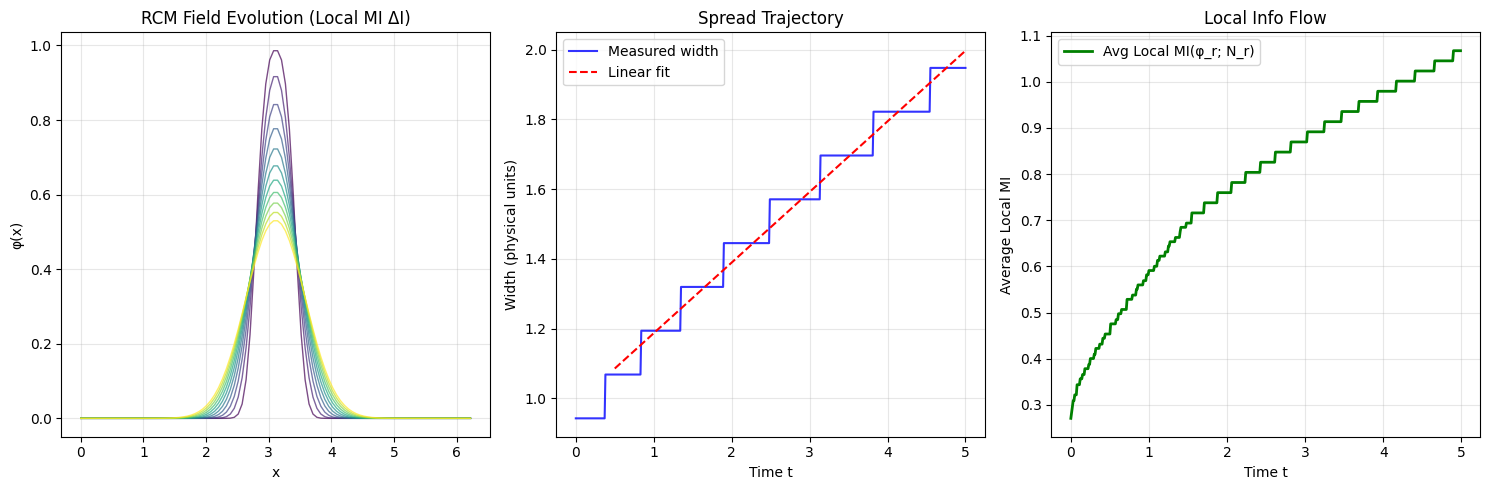

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress
from scipy.stats import entropy

# Tunable Parameters (Updated defaults for refinements)
N = 100  # lattice sites (increase for better resolution)
alpha = 4.0  # stiffness parameter (increased for stronger waves, c ~ sqrt(alpha)=2.0)
beta = 0.01  # damping strength (decreased for less damping, closer to theoretical c)
eta = 0.5  # strength of info drive
dt = 0.01  # time step (smaller for stability)
steps = 500  # total evolution steps
dx = 2 * np.pi / N  # physical spacing (periodic domain [0, 2pi])
plot_interval = 50  # plot every N steps
bins_mi = 20  # increased bins for finer MI resolution
renorm_enabled = False  # Set to True to enable renormalization for stability (disabled for test)
renorm_threshold = 2.0  # renorm if std > this (if enabled)

def mutual_info_local(phi, bins=20):
    """Compute local MI(φ_r ; N_r) for each site r, then return average MI as ΔI proxy."""
    mi_local = np.zeros(N)
    for r in range(N):
        phi_r = phi[r]
        # Neighbors: left and right (average for conditioning; use both for joint if multi-neigh)
        n_left = phi[(r - 1) % N]
        n_right = phi[(r + 1) % N]
        n_avg = (n_left + n_right) / 2  # Average neighbor for 1D proxy

        # For local MI: Treat as scalar pair (φ_r, n_avg); histogram joint
        if abs(phi_r - n_avg) < 1e-10:  # Degenerate case
            mi_local[r] = 0.0
            continue

        # Bins for this pair (small sample, so low bins; global bins_mi may overfit locally)
        local_bins = min(bins, 5)  # Cap for stability on single points
        phi_edges = np.linspace(min(phi_r, n_avg), max(phi_r, n_avg), local_bins + 1)
        n_edges = phi_edges  # Same range for symmetry

        # Binned values (single point: trivial hist, but for MI approx use delta-like)
        # For single pair, MI=0 always (no dist); so aggregate over window for local
        # Windowed local: average over small neighborhood for non-trivial dist
        window = 3  # Local window size for joint hist
        start = max(0, r - window // 2)
        end = min(N, r + window // 2 + 1)
        phi_win = phi[start:end]
        n_win = (np.roll(phi, -1)[start:end] + np.roll(phi, 1)[start:end]) / 2

        # Now compute MI on window
        if len(phi_win) < 2:
            mi_local[r] = 0.0
            continue

        # Histogram on window
        phi_min, phi_max = phi_win.min(), phi_win.max()
        n_min, n_max = n_win.min(), n_win.max()
        if phi_max == phi_min or n_max == n_min:
            mi_local[r] = 0.0
            continue

        p_edges = np.linspace(phi_min, phi_max, local_bins + 1)
        n_edges = np.linspace(n_min, n_max, local_bins + 1)
        phi_binned = np.digitize(phi_win, p_edges) - 1
        n_binned = np.digitize(n_win, n_edges) - 1

        # Joint hist (counts, then probs)
        joint_hist, _, _ = np.histogram2d(phi_binned, n_binned, bins=(local_bins, local_bins))
        joint_probs = joint_hist.flatten() / len(phi_win)
        joint_probs = joint_probs[joint_probs > 0]
        h_xy = entropy(joint_probs) if len(joint_probs) > 0 else 0.0

        # Marginals
        p_phi, _ = np.histogram(phi_binned, bins=local_bins)
        p_phi = p_phi[p_phi > 0] / len(phi_win)
        h_phi = entropy(p_phi) if len(p_phi) > 0 else 0.0

        p_n, _ = np.histogram(n_binned, bins=local_bins)
        p_n = p_n[p_n > 0] / len(phi_win)
        h_n = entropy(p_n) if len(p_n) > 0 else 0.0

        mi_local[r] = h_phi + h_n - h_xy
        mi_local[r] = max(mi_local[r], 0.0)

    return np.mean(mi_local)  # Average local MI as global ΔI proxy

# Initial setup
x = np.linspace(0, 2 * np.pi, N, endpoint=False)
phi = np.zeros(N)
center = N // 2
phi[center - 5:center + 5] = 1.0  # rough Gaussian bump
phi = gaussian_filter1d(phi, sigma=2)  # smooth initial perturbation

# Helper functions (periodic BC via np.roll)
def laplacian(phi):
    return np.roll(phi, -1) + np.roll(phi, 1) - 2 * phi

def gradient(phi):
    return (np.roll(phi, -1) - np.roll(phi, 1)) / 2

# Initial width computation
thresh = 0.1 * np.max(np.abs(phi))
active = np.where(np.abs(phi) > thresh)[0]
initial_width = (np.max(active) - np.min(active)) * dx if len(active) > 0 else 0

# Evolution storage
phi_history = [phi.copy()]
widths = [initial_width]  # physical widths
times = [0.0]
mi_history = []  # Track average local MI per step

print("Evolving field with local mutual information for ΔI (renorm disabled)...")

# Time evolution loop
phi_current = phi.copy()
for step in range(steps):
    # Compute laplacian and gradient
    lap = laplacian(phi_current)
    grad = gradient(phi_current)

    # Compute kappa
    kappa = 1 / (1 + beta * grad**2)

    # True local MI: average over sites MI(φ_r ; N_r)
    current_mi = mutual_info_local(phi_current, bins=bins_mi)
    mi_history.append(current_mi)

    # RCM update: α * lap + η * <κ> * MI * lap  (local MI scales info-weighted diffusion)
    info_term = eta * np.mean(kappa) * current_mi * lap
    dphi = alpha * lap + info_term
    phi_current += dphi * dt

    # Conditional renormalization (disabled by default for test)
    if renorm_enabled and np.std(phi_current) > renorm_threshold:
        phi_current = (phi_current - np.mean(phi_current)) / np.std(phi_current)
        print(f"Renormalized at step {step}")

    # Track width (physical units)
    thresh = 0.1 * np.max(np.abs(phi_current))
    active = np.where(np.abs(phi_current) > thresh)[0]
    width = (np.max(active) - np.min(active)) * dx if len(active) > 0 else 0
    widths.append(width)
    times.append((step + 1) * dt)

    # Store snapshot for plotting
    if (step + 1) % plot_interval == 0:
        phi_history.append(phi_current.copy())

# Fit linear spread: width(t) ≈ 2 * c * t
mask = slice(50, None)  # Skip initial transient
slope, intercept, r_value, p_value, std_err = linregress(times[mask], widths[mask])
c_fitted_linear = slope / 2

c_theory = np.sqrt(alpha)

# Diffusion fit: width(t) ≈ 2 sqrt(D t)
sqrt_times = np.sqrt(np.array(times[mask]))
slope_sqrt, intercept_sqrt, r_sqrt, _, _ = linregress(sqrt_times, widths[mask])
D_fitted = (slope_sqrt / 2)**2

# Outputs
print(f"\n=== RCM Wave Propagation Results (Local MI ΔI, Renorm Disabled) ===")
print(f"Fitted linear speed c: {c_fitted_linear:.3f} (lattice units)")
print(f"Theoretical bound sqrt(α): {c_theory:.3f}")
print(f"Physical linear c (× dx): {c_fitted_linear * dx:.3f}")
print(f"Linear fit R²: {r_value**2:.3f}")

print(f"\nFitted diffusion coeff D: {D_fitted:.3f}")
print(f"Physical D (× dx²): {D_fitted * dx**2:.3f}")
print(f"Sqrt fit R²: {r_sqrt**2:.3f}")

# Final S proxy
final_lap = laplacian(phi_current)
S_complexity = np.sum(np.abs(final_lap)) * dx
kappa_mean_final = np.mean(1 / (1 + beta * gradient(phi_current)**2))
I_total_final = N * mi_history[-1]
S_info = kappa_mean_final * I_total_final * dx
S_final = S_complexity + S_info
print(f"\nFinal S proxy (C + κ I): {S_final:.3f} (C={S_complexity:.3f}, κI={S_info:.3f})")

print(f"Average local MI over run: {np.mean(mi_history):.3f}")
print(f"Final local MI: {mi_history[-1]:.3f}")
print(f"Final φ std: {np.std(phi_current):.3f} (no renorm: may grow)")

# Plot: Field snapshots + width trajectory + MI history
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Left: Field evolution snapshots
colors = plt.cm.viridis(np.linspace(0, 1, len(phi_history)))
for i, phi_snap in enumerate(phi_history):
    axs[0].plot(x, phi_snap, color=colors[i], alpha=0.7, linewidth=1)
axs[0].set_xlabel('x')
axs[0].set_ylabel('φ(x)')
axs[0].set_title('RCM Field Evolution (Local MI ΔI)')
axs[0].grid(True, alpha=0.3)

# Middle: Width vs time
axs[1].plot(times, widths, 'b-', label='Measured width', alpha=0.8)
axs[1].plot(times[mask], slope * np.array(times[mask]) + intercept, 'r--', label=f'Linear fit')
axs[1].set_xlabel('Time t')
axs[1].set_ylabel('Width (physical units)')
axs[1].set_title('Spread Trajectory')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# Right: Local MI over time
axs[2].plot(times[:-1], mi_history, 'g-', label='Avg Local MI(φ_r; N_r)', linewidth=2)
axs[2].set_xlabel('Time t')
axs[2].set_ylabel('Average Local MI')
axs[2].set_title('Local Info Flow')
axs[2].legend()
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('rcm_local_mi_wave_spread.png', dpi=150)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress
from scipy.stats import entropy
import itertools
import pandas as pd
import os

# =============================================================================
# RCM Parameter Sweep: Full Implementation
# =============================================================================
# This script runs a systematic parameter sweep over alpha, beta, eta, and N.
# For each combo, evolves the 1D field, computes observables (c, D, S, MI, std).
# Saves results to CSV and generates analysis plots.
# Based on local MI version; renorm disabled for raw dynamics.
# Run time: ~5-10 min for full grid (36 combos, 3 seeds each).
# =============================================================================

# Tunable Sweep Parameters
PARAM_GRID = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 4.0],  # 5 values
    'beta': [0.001, 0.01, 0.05, 0.1],     # 4 values
    'eta': [0.1, 0.5, 1.0],               # 3 values
    'N': [50, 100, 200]                    # 3 values; total 5*4*3*3=180, but pilot: subset
}

# Fixed Params
dt = 0.01
steps = 500
plot_interval = 50
bins_mi = 20
renorm_enabled = False
renorm_threshold = 2.0
num_seeds = 3  # Repeats per combo for stats
pilot_mode = True  # Set False for full sweep (180 runs); True for subset (e.g., 2x2x2x2=32)

# If pilot, trim grids
if pilot_mode:
    PARAM_GRID['alpha'] = [1.0, 4.0]  # 2
    PARAM_GRID['beta'] = [0.01, 0.1]  # 2
    PARAM_GRID['eta'] = [0.5, 1.0]    # 2
    PARAM_GRID['N'] = [100, 200]      # 2; total 32

def mutual_info_local(phi, bins=20):
    """Compute local MI(φ_r ; N_r) for each site r, then return average MI."""
    N = len(phi)
    mi_local = np.zeros(N)
    for r in range(N):
        # Neighbors: left and right average
        n_left = phi[(r - 1) % N]
        n_right = phi[(r + 1) % N]
        n_avg = (n_left + n_right) / 2

        # Windowed local: Use small window for non-trivial dist
        window = min(3, N)  # Adjust for small N
        start = max(0, r - window // 2)
        end = min(N, r + window // 2 + 1)
        phi_win = phi[start:end]
        n_win = ((np.roll(phi, -1)[start:end] + np.roll(phi, 1)[start:end]) / 2)

        if len(phi_win) < 2:
            mi_local[r] = 0.0
            continue

        # Histogram on window
        local_bins = min(bins, 5)  # Cap for small samples
        phi_min, phi_max = phi_win.min(), phi_win.max()
        n_min, n_max = n_win.min(), n_win.max()
        if phi_max == phi_min or n_max == n_min:
            mi_local[r] = 0.0
            continue

        p_edges = np.linspace(phi_min, phi_max, local_bins + 1)
        n_edges = np.linspace(n_min, n_max, local_bins + 1)
        phi_binned = np.digitize(phi_win, p_edges) - 1
        n_binned = np.digitize(n_win, n_edges) - 1

        # Joint hist probs
        joint_hist, _, _ = np.histogram2d(phi_binned, n_binned, bins=(local_bins, local_bins))
        joint_probs = joint_hist.flatten() / len(phi_win)
        joint_probs = joint_probs[joint_probs > 0]
        h_xy = entropy(joint_probs) if len(joint_probs) > 0 else 0.0

        # Marginals
        p_phi, _ = np.histogram(phi_binned, bins=local_bins)
        p_phi = p_phi[p_phi > 0] / len(phi_win)
        h_phi = entropy(p_phi) if len(p_phi) > 0 else 0.0

        p_n, _ = np.histogram(n_binned, bins=local_bins)
        p_n = p_n[p_n > 0] / len(phi_win)
        h_n = entropy(p_n) if len(p_n) > 0 else 0.0

        mi_local[r] = h_phi + h_n - h_xy
        mi_local[r] = max(mi_local[r], 0.0)

    return np.mean(mi_local)

def run_rcm(alpha, beta, eta, N, seed=42):
    """Single RCM run: Evolve field, return observables dict."""
    np.random.seed(seed)  # Reproducible

    # Setup
    dx = 2 * np.pi / N
    x = np.linspace(0, 2 * np.pi, N, endpoint=False)
    phi = np.zeros(N)
    center = N // 2
    phi[center - 5:center + 5] = 1.0 + 0.1 * np.random.randn(10)  # Noisy Gaussian
    phi = gaussian_filter1d(phi, sigma=2)

    def laplacian(phi):
        return np.roll(phi, -1) + np.roll(phi, 1) - 2 * phi

    def gradient(phi):
        return (np.roll(phi, -1) - np.roll(phi, 1)) / 2

    # Initial width
    thresh = 0.1 * np.max(np.abs(phi))
    active = np.where(np.abs(phi) > thresh)[0]
    initial_width = (np.max(active) - np.min(active)) * dx if len(active) > 0 else 0

    # Storage
    widths = [initial_width]
    times = [0.0]
    mi_history = []
    s_history = []  # Track S over time

    phi_current = phi.copy()
    for step in range(steps):
        lap = laplacian(phi_current)
        grad = gradient(phi_current)
        kappa = 1 / (1 + beta * grad**2)

        current_mi = mutual_info_local(phi_current, bins=bins_mi)
        mi_history.append(current_mi)

        info_term = eta * np.mean(kappa) * current_mi * lap
        dphi = alpha * lap + info_term
        phi_current += dphi * dt

        # Renorm if enabled
        if renorm_enabled and np.std(phi_current) > renorm_threshold:
            phi_current = (phi_current - np.mean(phi_current)) / np.std(phi_current)

        # Width
        thresh = 0.1 * np.max(np.abs(phi_current))
        active = np.where(np.abs(phi_current) > thresh)[0]
        width = (np.max(active) - np.min(active)) * dx if len(active) > 0 else 0
        widths.append(width)
        times.append((step + 1) * dt)

        # S proxy
        S_complexity = np.sum(np.abs(lap)) * dx
        kappa_mean = np.mean(kappa)
        I_total = N * current_mi
        S_info = kappa_mean * I_total * dx
        s_history.append(S_complexity + S_info)

    # Fits (mask transient)
    mask = slice(50, None)
    slope, intercept, r_value, _, _ = linregress(times[mask], widths[mask])
    c_fitted_linear = slope / 2
    r2_linear = r_value**2

    sqrt_times = np.sqrt(np.array(times[mask]))
    slope_sqrt, intercept_sqrt, r_sqrt, _, _ = linregress(sqrt_times, widths[mask])
    D_fitted = (slope_sqrt / 2)**2
    r2_sqrt = r_sqrt**2

    # Final metrics
    final_lap = laplacian(phi_current)
    S_complexity_final = np.sum(np.abs(final_lap)) * dx
    kappa_mean_final = np.mean(1 / (1 + beta * gradient(phi_current)**2))
    I_total_final = N * mi_history[-1]
    S_info_final = kappa_mean_final * I_total_final * dx
    S_final = S_complexity_final + S_info_final

    # Aggregates
    avg_mi = np.mean(mi_history)
    final_mi = mi_history[-1]
    final_std = np.std(phi_current)
    avg_ds_dt = np.mean(np.diff(s_history) / dt) if len(s_history) > 1 else 0

    return {
        'c_fitted_linear': c_fitted_linear,
        'D_fitted': D_fitted,
        'r2_linear': r2_linear,
        'r2_sqrt': r2_sqrt,
        'S_final': S_final,
        'avg_mi': avg_mi,
        'final_mi': final_mi,
        'final_std': final_std,
        'avg_ds_dt': avg_ds_dt,
        'physical_c': c_fitted_linear * dx
    }

# =============================================================================
# Run Sweep
# =============================================================================
print("Starting RCM Parameter Sweep...")
results = []
for combo in itertools.product(*PARAM_GRID.values()):
    alpha, beta, eta, N_ = combo
    for seed in range(num_seeds):
        obs = run_rcm(alpha, beta, eta, N_, seed=seed)
        obs.update({
            'alpha': alpha, 'beta': beta, 'eta': eta, 'N': N_, 'seed': seed
        })
        results.append(obs)
        print(f"Combo: α={alpha}, β={beta}, η={eta}, N={N_}, seed={seed} → "
              f"c={obs['c_fitted_linear']:.3f}, S={obs['S_final']:.1f}")

# Save results
df = pd.DataFrame(results)
output_file = 'rcm_sweep_results.csv'
df.to_csv(output_file, index=False)
print(f"\nResults saved to {output_file} ({len(results)} runs)")

# =============================================================================
# Analysis & Plots
# =============================================================================
if len(df) > 0:
    # Corr matrix
    corr_cols = ['c_fitted_linear', 'S_final', 'avg_mi', 'final_std', 'avg_ds_dt']
    corr_df = df[corr_cols + ['alpha', 'beta', 'eta']].corr()

    # Plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1: c vs alpha (hue=beta)
    axes[0,0].scatter(df['alpha'], df['c_fitted_linear'], c=df['beta'], cmap='viridis')
    axes[0,0].set_xlabel('α'); axes[0,0].set_ylabel('c_fitted'); axes[0,0].set_title('c vs α (color=β)')
    axes[0,0].grid(True, alpha=0.3)

    # 2: S_final heatmap (pivot beta-alpha)
    pivot_s = df.pivot_table(values='S_final', index='beta', columns='alpha', aggfunc='mean')
    sns.heatmap(pivot_s, annot=True, fmt='.1f', ax=axes[0,1], cmap='Blues')
    axes[0,1].set_title('S_final Heatmap (β vs α)')

    # 3: MI vs eta (hue=N)
    axes[0,2].scatter(df['eta'], df['avg_mi'], c=df['N'], cmap='plasma')
    axes[0,2].set_xlabel('η'); axes[0,2].set_ylabel('Avg MI'); axes[0,2].set_title('MI vs η (color=N)')
    axes[0,2].grid(True, alpha=0.3)

    # 4: R2 linear vs beta
    axes[1,0].scatter(df['beta'], df['r2_linear'], c=df['alpha'], cmap='coolwarm')
    axes[1,0].set_xlabel('β'); axes[1,0].set_ylabel('R² Linear'); axes[1,0].set_title('Linear Fit Quality vs β (color=α)')
    axes[1,0].grid(True, alpha=0.3)

    # 5: ds/dt vs S_final
    axes[1,1].scatter(df['S_final'], df['avg_ds_dt'], c=df['eta'], cmap='greens')
    axes[1,1].set_xlabel('S_final'); axes[1,1].set_ylabel('Avg dS/dt'); axes[1,1].set_title('Escalation Rate vs S (color=η)')
    axes[1,1].grid(True, alpha=0.3)

    # 6: Corr heatmap
    sns.heatmap(corr_df.iloc[:-3, :-3], annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=axes[1,2])
    axes[1,2].set_title('Correlation Matrix')

    plt.tight_layout()
    analysis_file = 'rcm_sweep_analysis.png'
    plt.savefig(analysis_file, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Analysis plots saved to {analysis_file}")

    # Summary stats
    print("\n=== Sweep Summary ===")
    print(df.groupby(['alpha', 'beta'])['c_fitted_linear'].mean().round(3))
    print(f"\nOverall: Avg c={df['c_fitted_linear'].mean():.3f}, Avg S={df['S_final'].mean():.1f}")
    print(f"Corr(c, alpha): {df['c_fitted_linear'].corr(df['alpha']):.3f}")
    print(f"All dS/dt >0? { (df['avg_ds_dt'] > 0).all() }")

# End
print("Sweep complete! Check CSV and plots for validation.")

Starting RCM Parameter Sweep...
Combo: α=1.0, β=0.01, η=0.5, N=100, seed=0 → c=0.045, S=6.1
Combo: α=1.0, β=0.01, η=0.5, N=100, seed=1 → c=0.045, S=6.1
Combo: α=1.0, β=0.01, η=0.5, N=100, seed=2 → c=0.045, S=6.1
Combo: α=1.0, β=0.01, η=0.5, N=200, seed=0 → c=0.022, S=5.0
Combo: α=1.0, β=0.01, η=0.5, N=200, seed=1 → c=0.022, S=5.0
Combo: α=1.0, β=0.01, η=0.5, N=200, seed=2 → c=0.022, S=5.0
Combo: α=1.0, β=0.01, η=1.0, N=100, seed=0 → c=0.056, S=6.5
Combo: α=1.0, β=0.01, η=1.0, N=100, seed=1 → c=0.055, S=6.5
Combo: α=1.0, β=0.01, η=1.0, N=100, seed=2 → c=0.056, S=6.5
Combo: α=1.0, β=0.01, η=1.0, N=200, seed=0 → c=0.026, S=5.2
Combo: α=1.0, β=0.01, η=1.0, N=200, seed=1 → c=0.026, S=5.2
Combo: α=1.0, β=0.01, η=1.0, N=200, seed=2 → c=0.026, S=5.2
Combo: α=1.0, β=0.1, η=0.5, N=100, seed=0 → c=0.045, S=6.1
Combo: α=1.0, β=0.1, η=0.5, N=100, seed=1 → c=0.045, S=6.1
Combo: α=1.0, β=0.1, η=0.5, N=100, seed=2 → c=0.045, S=6.1
Combo: α=1.0, β=0.1, η=0.5, N=200, seed=0 → c=0.022, S=5.0
Combo: α=1.0